# Slot Attention: warm-up

**Goal:** In slot attention mini, I was trying to _make sure_ that I was in a good place for this problem by

1. Seeing if I could get a good learning rate schedule for the optimization
2. Adding back positional embeddings 
3. Seeing if the final res net block is helpful or not

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import torch
import torch.nn.functional as F

import os
os.sys.path.append('code')

from model import SlotAttentionEncoder, build_grid # Lukas's slot attention code
from data import gen_events

%load_ext autoreload
%autoreload 2

**Functions that I'm copying over from before**

In [2]:
nPixels = 32

xlow = -0.5
xhigh = 0.5
binWidth = (xhigh-xlow)/(nPixels+1)

stdlow = 0.01
stdhigh = 0.05

bins = np.arange(xlow,xhigh,binWidth)

nBins = len(bins)-1

In [3]:
def make_batch(bs,device='cpu'):
    
    # Load in data from Florian's fct
    centers,img_Es = gen_events(bins, N_events=bs)
    
    # Convert to a torch tensor
    X = torch.FloatTensor(img_Es).to(device).permute(0,3,1,2)
    Y = torch.FloatTensor(centers[:,0,:3]).to(device)
    
    # Get the semantic segmentation mask
    mask = (X > 0).float()
    
    return X, Y, mask

## 1. Learning Rate optimization

### 1a) Learning rate warm-up

**Motivation:** (two fold)

**1. Theoretical**

[1706.02677](https://arxiv.org/abs/1706.02677) introduced a learning rate warm-up so that they could use super large batch sizes to train the networks much faster, and still get ~ optimal performance.

<img src="1706.02677-fig2.png" style="height:300px"  />

   Metrics:
   - Save the training loss curve from the batch-size of <span style="color: red;">256</span> in the `SA-mini` notebook
    - Overlay the curve with the same batch size, but with warm-up
        **Hope:** With warm-up, it will be _lower_
    - Then increase the batch-size and learning rate, and _hopefully_ we will train _faster_, but still converge to a good minimim with warm-up :)
    
**2. Empirical**

The motivation for the learning rate warm up was "to prevent early saturation of the attention mechanism."

Metrics:
- Plot the slots and the gradients with respect to the logits

In [73]:
np.sqrt(32)

5.656854249492381

In [67]:
class SlotAttentionMini(torch.nn.Module):
    def __init__(self, 
                 k_slots=3, 
                 hidden_dim=32, 
                 query_dim=32, 
                 n_iter=2,
                 device='cpu', 
                 ):
        '''
        Slot attention encoder block

        Inputs:
        - device (cpu, mps, cuda): Which device to put the model on 
                (needed for the random call when initializing the slots)
        - k_slots: number of slots (note, can vary between training and test time)
        - hidden_dim: The hidden dimension for the CNN (currently single layer w/ no non-linearities)
        - query_dim: The latent space dimension that the slots and the queries get computed in
        - n_iter: Number of slot attention steps to apply (defualt 2, and rn hard coded)
        '''
        super().__init__()

        self.k_slots = k_slots
        self.hidden_dim = hidden_dim
        self.query_dim = query_dim
        self.n_iter = n_iter

        self.device=device
        
        self.dataN = torch.nn.LayerNorm(self.hidden_dim)
        self.queryN = torch.nn.LayerNorm(self.query_dim)
        
        self.toK = torch.nn.Linear(self.hidden_dim, self.query_dim)
        self.toV = torch.nn.Linear(self.hidden_dim, self.query_dim)
        self.gru = torch.nn.GRUCell(self.query_dim, self.query_dim)

        filter_size=5
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1,self.hidden_dim,filter_size, padding = 2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(self.hidden_dim,self.hidden_dim,filter_size, padding = 2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(self.hidden_dim,self.hidden_dim,filter_size, padding = 2),
        )   
        
        # I think _in theory_ this is where the positional embedding should go too
        self.posEnc = -1
        
    def init_slots(self, Nbatch):
        noise = torch.randn(Nbatch, self.k_slots, self.query_dim).to(self.device)
        
        mu = torch.zeros(1,1,self.query_dim).to(self.device)
        logsigma = torch.zeros(1,1,self.query_dim).to(self.device)
        
        return mu + noise*logsigma.exp()
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
            
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    def attention_and_weights(self,queries,encoded_data):
        keys = self.toK(encoded_data)
        logits = torch.einsum('bse,bde->bsd',queries,keys) * (self.query_dim ** (-0.5)) * 10
        
        if logits.requires_grad:
            h = logits.register_hook(self.activations_hook)
        
        att = torch.nn.functional.softmax(logits, dim = 1)

        div = torch.sum(att, dim = -1, keepdims = True)
        wts = att/div + 1e-8
        return att,wts

    def iterate(self, queries, encoded_data):
        
        # queries: (bs, n_slots, query_dim)
        
        att,wts = self.attention_and_weights(self.queryN(queries),encoded_data)   
        
        # att: (bs, n_slots, img_dim)
        # wts: (bs, n_slots, img_dim)
        
        vals = self.toV(encoded_data) # bs, img_dim, query_dim
        updates = torch.einsum('bsd,bde->bse',wts,vals) # bs, n_slots, query_dim
        
        updates = self.gru(
            updates.reshape(-1,self.query_dim),
            queries.reshape(-1,self.query_dim),
        )

        return updates.reshape(queries.shape)
        
    def forward(self, data):

        Nbatch = data.shape[0]
        
        # Initialize the queries
        queries = self.init_slots(Nbatch) # Shape (Nbatch, query_dim)
        
        # Apply the CNN encoder
        encoded_data = self.encoder(data)
        
        # Add the positional embeddings
        # encoded_data = self.posEnc
       
        # Flatten the pixel dims and apply the data normalization
        encoded_data = torch.permute(encoded_data,(0,2,3,1)) 
        encoded_data = torch.flatten(encoded_data,1,2)
        encoded_data = self.dataN(encoded_data)
    
        for i in range(self.n_iter):
            queries = self.iterate(queries, encoded_data)    
            
        # Then with the _final_ query vector, calc what the attn + weights would be
        att, wts = self.attention_and_weights(self.queryN(queries),encoded_data)   
            
        return queries, att #.reshape(-1,self.k_slots,nPixels,nPixels)
        

In [5]:
n_rings_max = 1
k_slots = 2

In [17]:
def hungarian_bce_one_ring(att, mask,bs):
    '''
    Hungarian section Translated from the TensorFlow loss function (from 2006.15055 code):
    https://github.com/nhartman94/google-research/blob/master/slot_attention/utils.py#L26-L57
    '''
    
    flat_mask = mask.reshape(-1,1, nPixels*nPixels)[:,None,:,:]
    
    att_ext  = torch.tile(att,  dims=(1,1,n_rings_max,1)).reshape(bs * k_slots * n_rings_max , nPixels**2)
    mask_ext = torch.tile(flat_mask,dims=(1,k_slots,1,1)).reshape(bs * k_slots * n_rings_max , nPixels**2)
    
    pairwise_cost = F.binary_cross_entropy(att_ext,mask_ext,reduction='none').mean(axis=-1)
    pairwise_cost = pairwise_cost.reshape(bs, k_slots, n_rings_max)
    
    with torch.no_grad():
        indices = list(map(linear_sum_assignment, pairwise_cost.cpu())) #np.array())
        indices = torch.LongTensor(indices)
    
    losses = pairwise_cost[torch.arange(bs),indices[:,0,0],indices[:,1,0]]
    
    return torch.mean(losses)
    

In [62]:
from scipy.optimize import linear_sum_assignment

In [63]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device='cpu'

In [64]:
bs = 2
# device='cpu'

X,Y,mask = make_batch(2,device)

In [68]:
sa = SlotAttentionMini(k_slots=2,device=device).to(device)

X = X.to(device)

with torch.no_grad():
    queries, att = sa(X)

In [69]:
def plot_2slots_1ring(losses, mask, att,color='C0',cmap='Blues'):
    
    fig, axs = plt.subplots(1,4,figsize=(10,3))

    axs[0].plot(losses,color=color)
    axs[0].set_title('Loss')
    
    for i, (ax,img,title) in enumerate(zip(axs[1:],[mask,att[0],att[1]],
                                        ['Target','Slot 0','Slot 1'])):

        im = ax.imshow(img,cmap=cmap,vmin=0,vmax=1)

        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')

        ax.set_title(title)

        ax.axis('off')
        
    plt.show()

In [70]:
def plotAttnMapsGrads(model,mask,att,iEvt=0,cmap='Blues'):
    '''
    Goal: Plot the attention maps and the gradients 
    of the logits for each of the slots.
    
    
    Inputs:
    - model: Needs to have the "hook" registered so that 
             `model.gradients` reut
    - mask: Ground truth
    - att: attention maps
    - iEvt (0) : Which event to plot 
    - cmap ('Blues'): What colormap to use
    '''
    fig, ax = plt.subplots(2,3,figsize=(9,6))

    # Plot X 

    im = ax[0,0].imshow(mask[iEvt].squeeze().cpu().numpy(),cmap=cmap)
    ax[0,0].set_title('Ground truth')

    divider = make_axes_locatable(ax[0,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    # Plot slots and the attn gradients
    for i in range(k_slots):

        # slot
        im = ax[i,1].imshow(att.detach().cpu().numpy()[iEvt,i].reshape(nPixels,nPixels),cmap=cmap,vmin=0,vmax=1)
        ax[i,1].set_title(f'Slot {i}')

        divider = make_axes_locatable(ax[i,1])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')

        # grad
        im = ax[i,2].imshow(model.gradients.detach().cpu().numpy()[iEvt,i].reshape(nPixels,nPixels),cmap=cmap)
        ax[i,2].set_title(f'Grad {i}')

        divider = make_axes_locatable(ax[i,2])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')

    for ax_ij in ax.flatten():
        ax_ij.axis('off')

    plt.show()

In [71]:
def train_wu(model, Ntrain = 5000, bs=32, device='cpu', color='C0',cmap='Blues'):
    '''
    train
    -----------
    
    - model
    - Ntrain: # of training iterations
    - color,cmap -- options that get passed the
    '''

    # Learning rate schedule config
    base_learning_rate = 3e-4
    warmup_steps = 1_000
    opt = torch.optim.Adam(model.parameters(), base_learning_rate)
    model.train()
    losses = []
    
    for i in range(Ntrain):

        if i < warmup_steps:
            learning_rate = (i / warmup_steps) * base_learning_rate
        
        opt.param_groups[0]['lr'] = learning_rate
        
        X, Y, mask = make_batch(bs,device)
        
        queries, att = model(X)
            
        loss = hungarian_bce_one_ring(att,mask,bs=bs)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        losses.append(float(loss))
        
        if i % 250 == 0:
            print('iter',i,', loss',loss.detach().cpu().numpy(),', lr',opt.param_groups[0]['lr'])
            
            iEvt = 0
            att_img = att[iEvt].reshape(sa.k_slots,nPixels,nPixels)
            plot_2slots_1ring(losses, 
                              mask[iEvt,0].detach().cpu().numpy(), 
                              att_img.detach().cpu().numpy(),
                              color=color,cmap=cmap)

            plotAttnMapsGrads(model,mask,att,iEvt,cmap)
            
    model.eval()
    return model,losses

iter 0 , loss 0.7726311 , lr 0.0


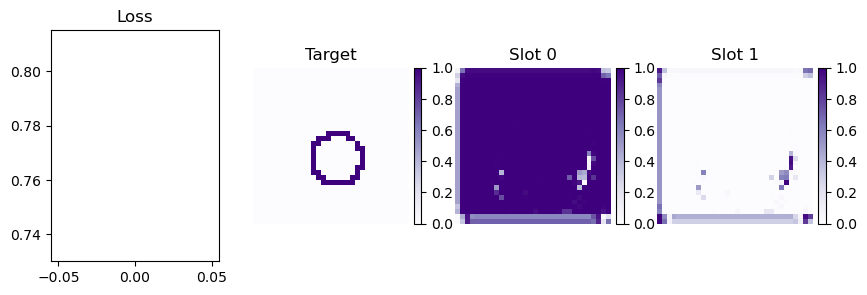

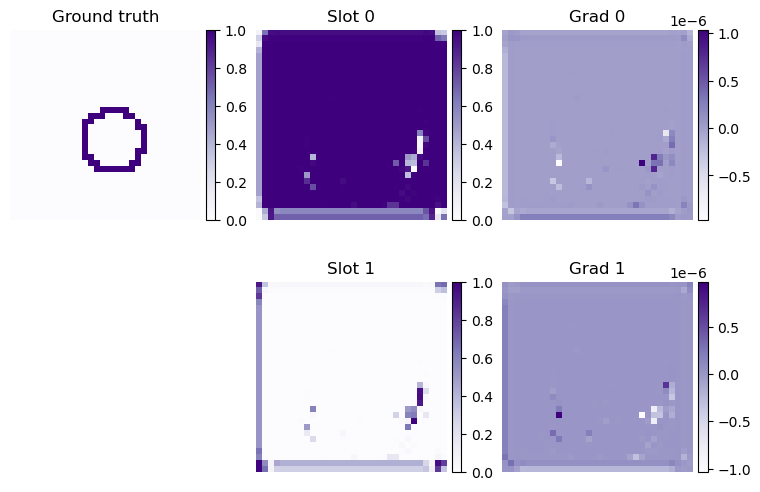

iter 250 , loss 0.568293 , lr 7.5e-05


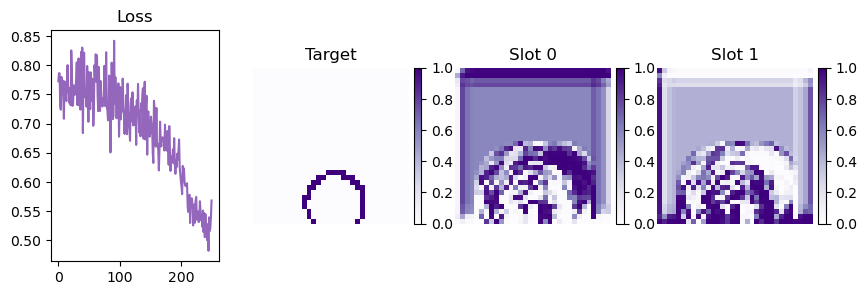

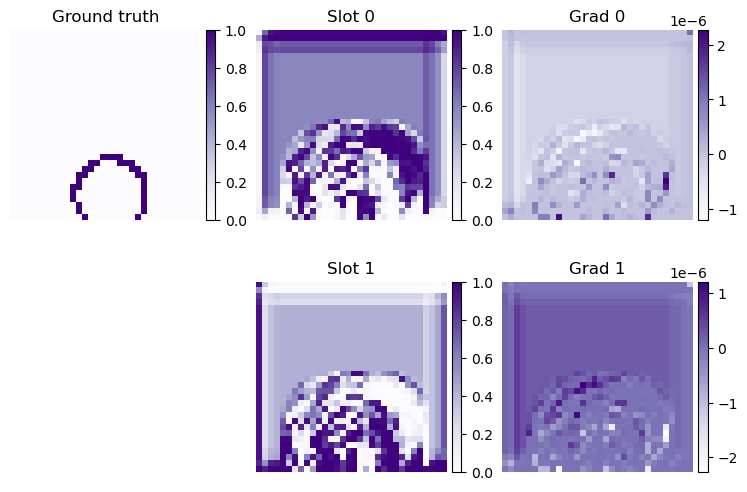

iter 500 , loss 0.3585587 , lr 0.00015


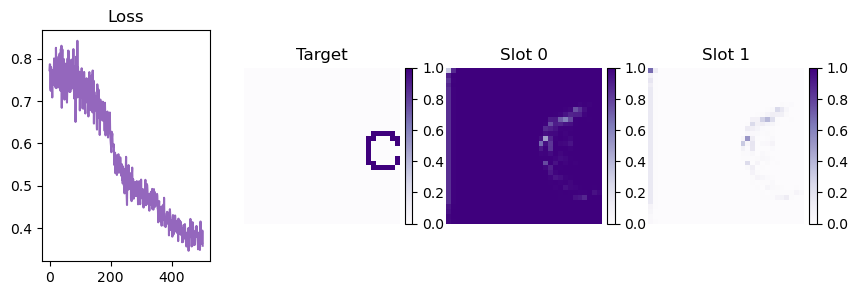

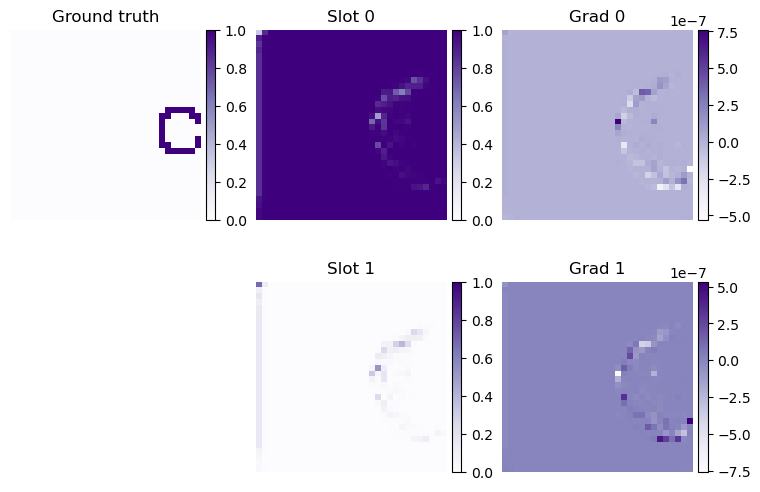

iter 750 , loss 0.35920537 , lr 0.000225


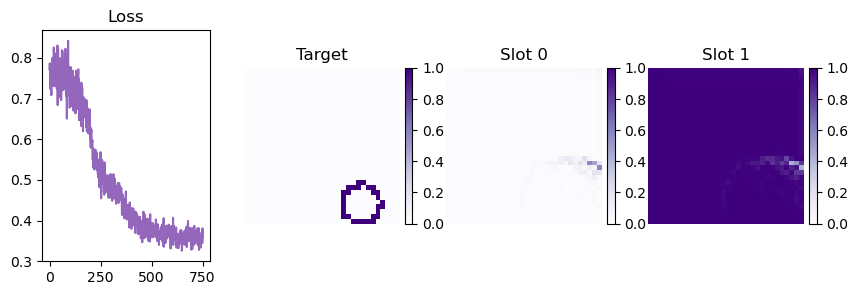

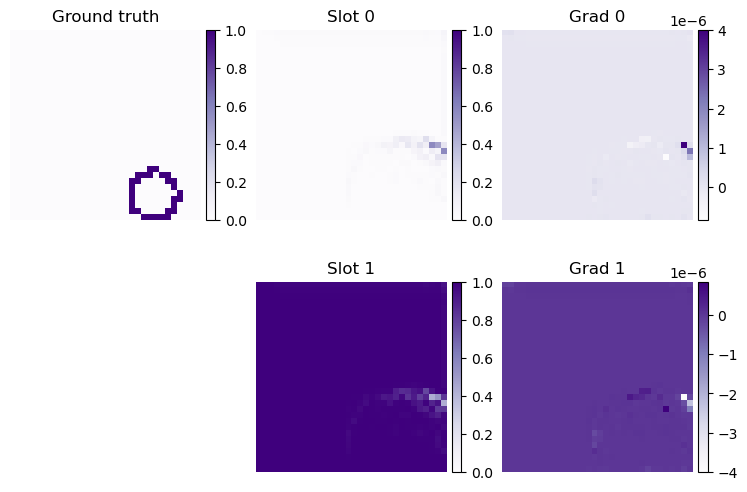

iter 1000 , loss 0.3310114 , lr 0.00029969999999999997


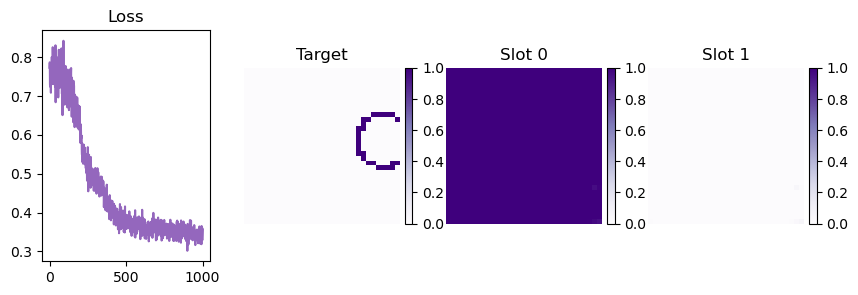

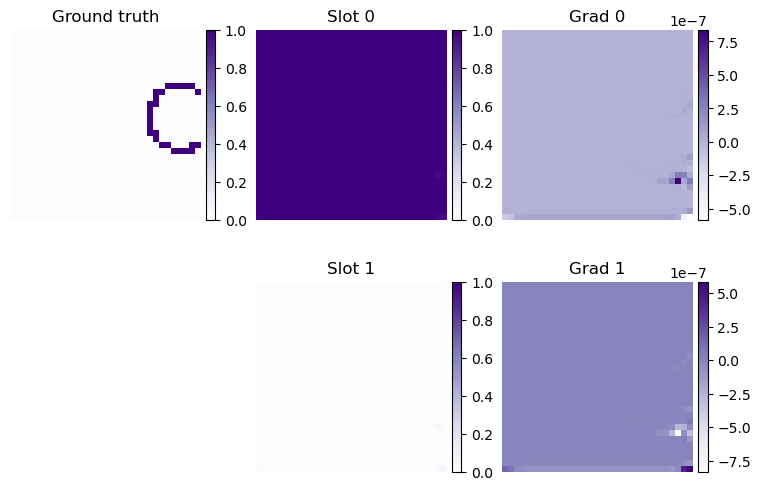

iter 1250 , loss 0.33019385 , lr 0.00029969999999999997


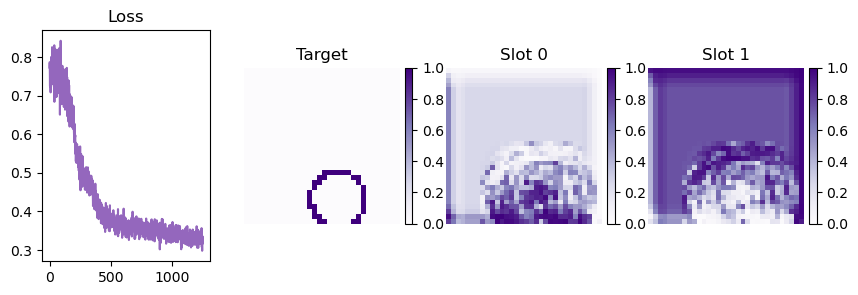

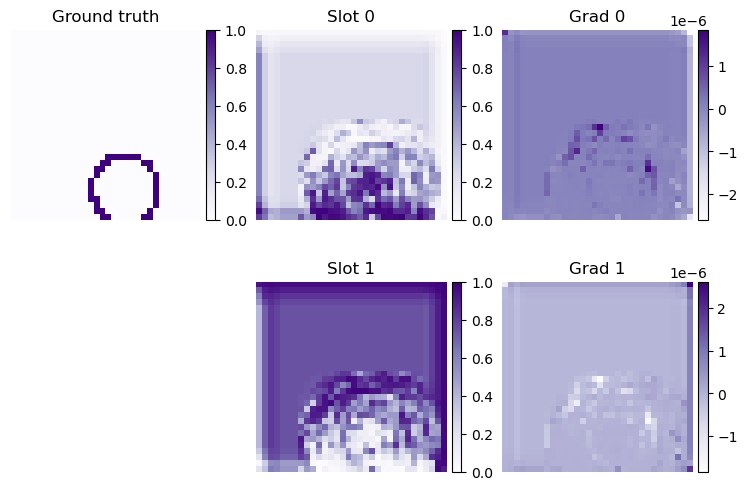

iter 1500 , loss 0.34976426 , lr 0.00029969999999999997


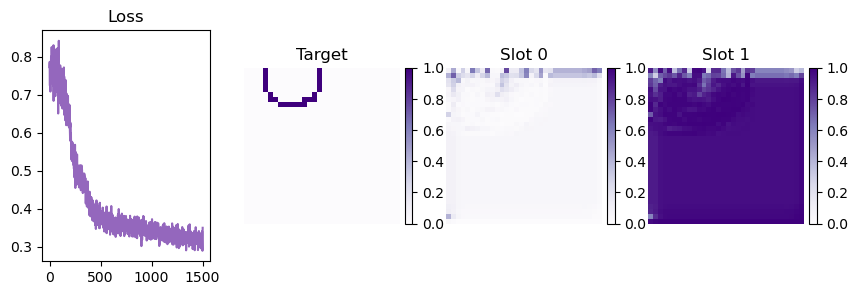

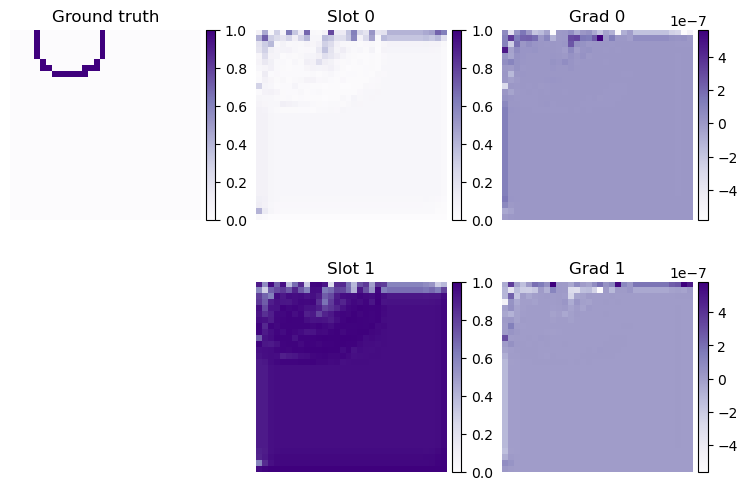

iter 1750 , loss 0.31314635 , lr 0.00029969999999999997


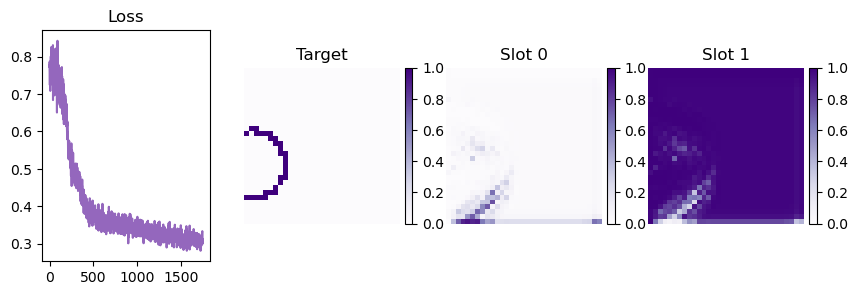

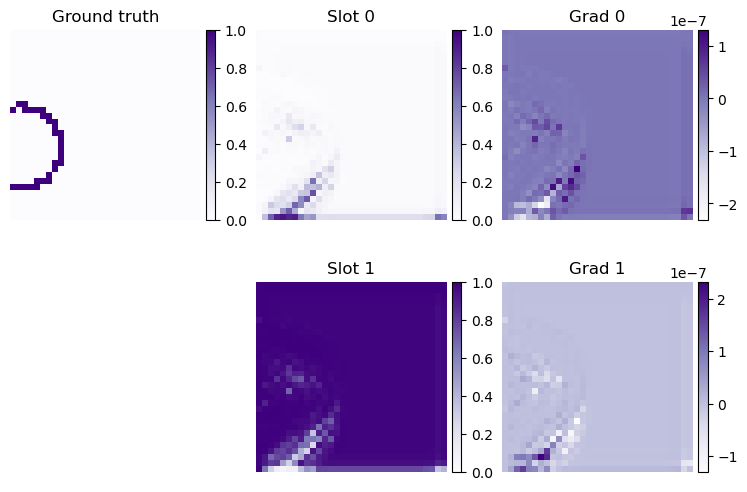

iter 2000 , loss 0.29924732 , lr 0.00029969999999999997


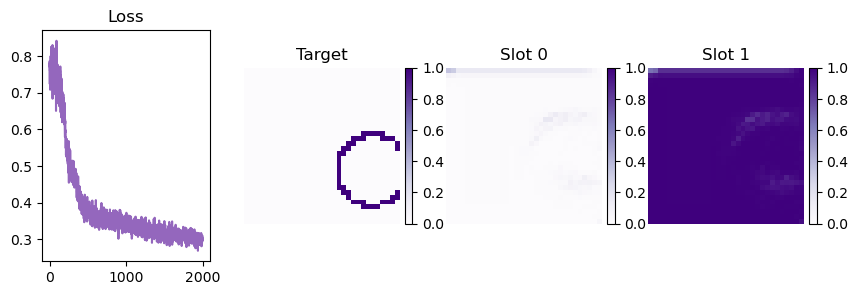

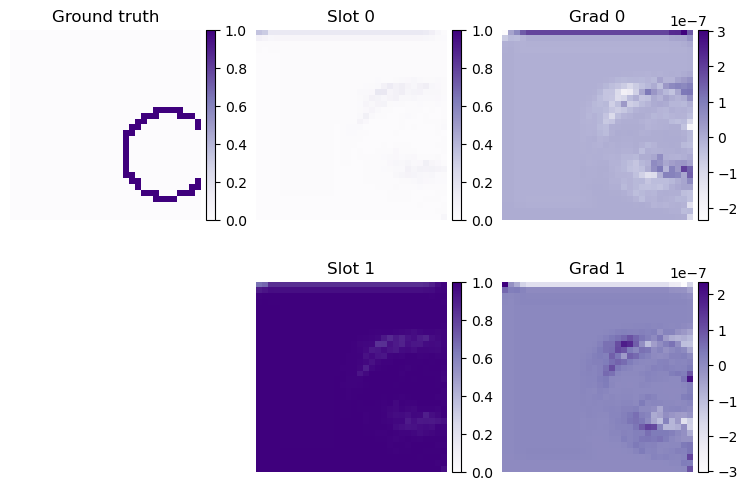

iter 2250 , loss 0.30368882 , lr 0.00029969999999999997


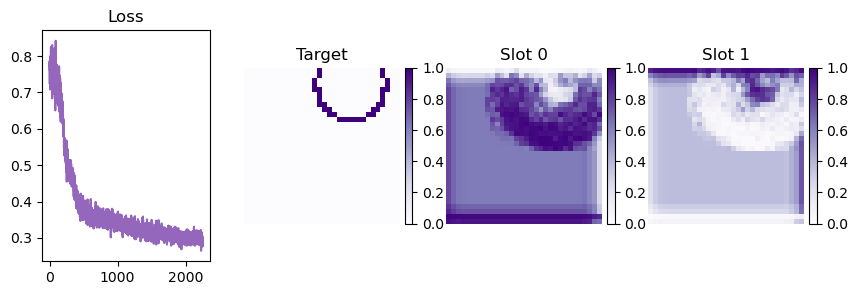

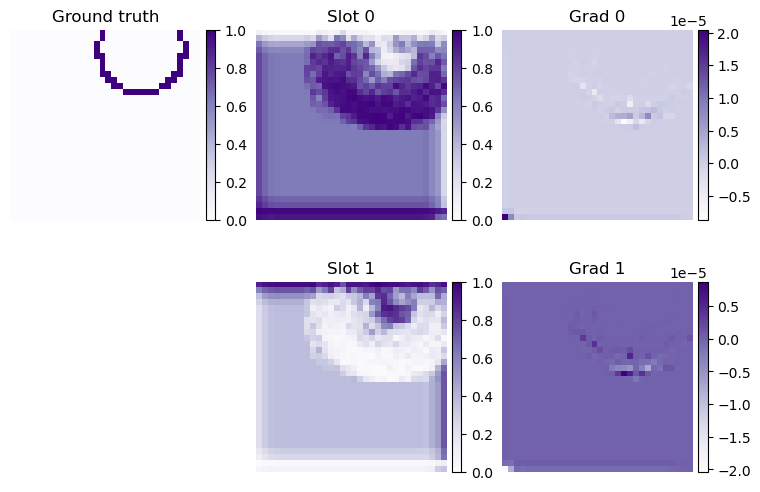

iter 2500 , loss 0.28000063 , lr 0.00029969999999999997


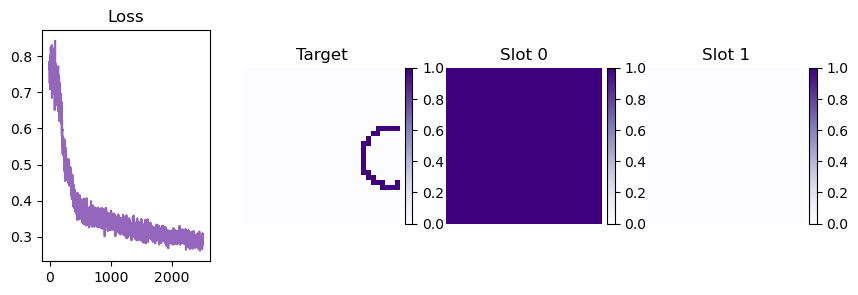

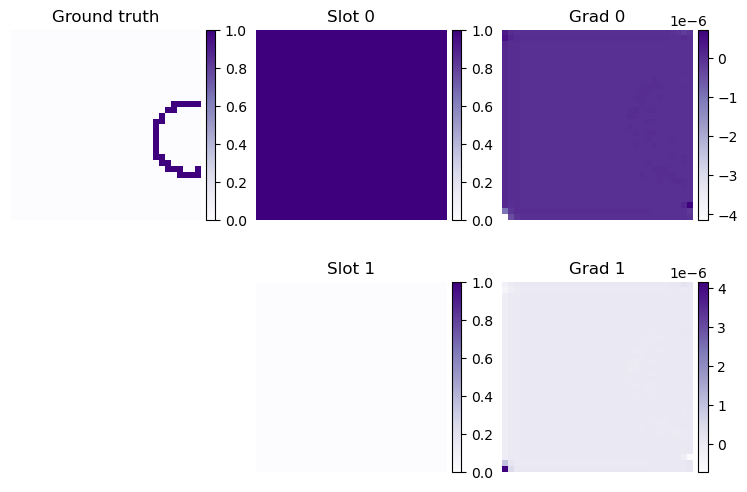

iter 2750 , loss 0.26878363 , lr 0.00029969999999999997


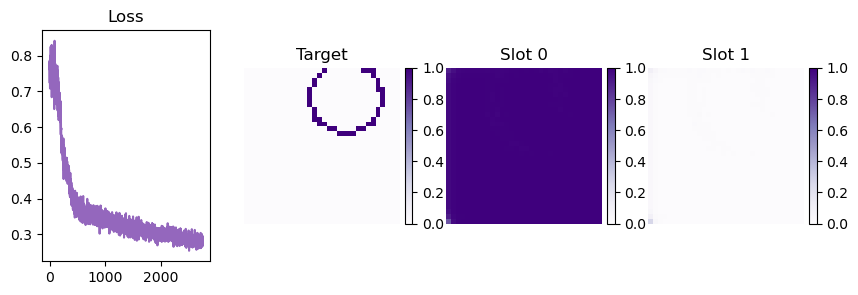

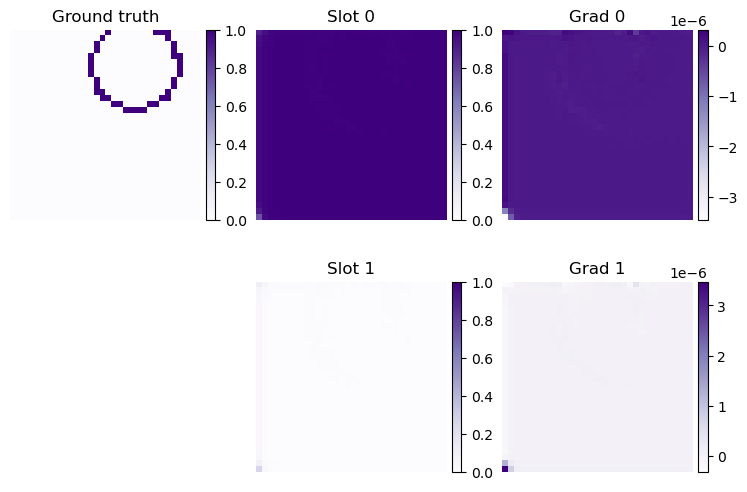

iter 3000 , loss 0.2794 , lr 0.00029969999999999997


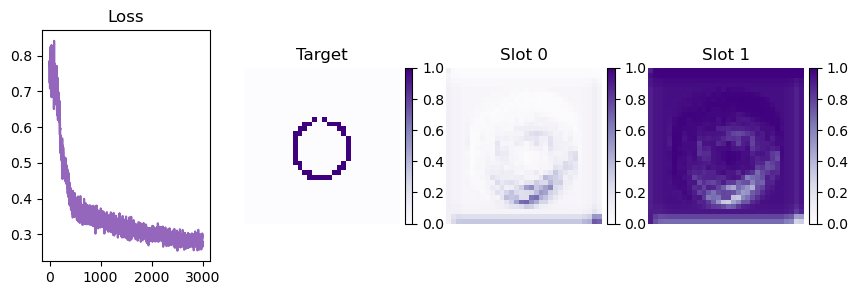

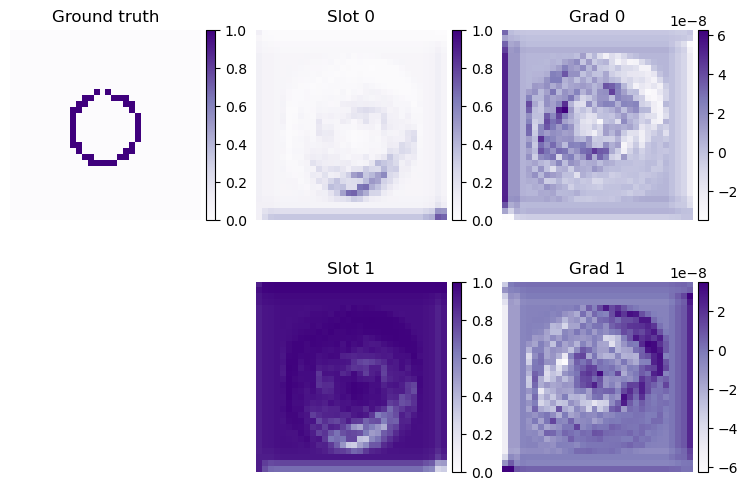

iter 3250 , loss 0.28815734 , lr 0.00029969999999999997


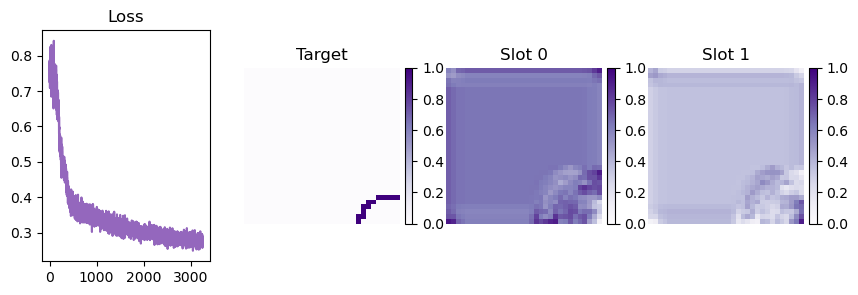

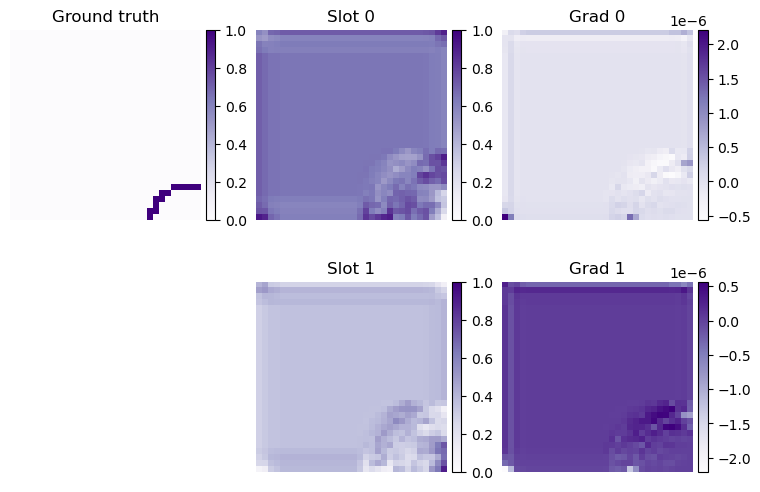

iter 3500 , loss 0.2979967 , lr 0.00029969999999999997


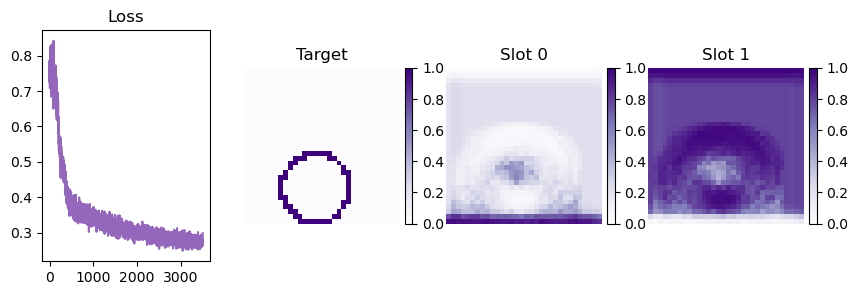

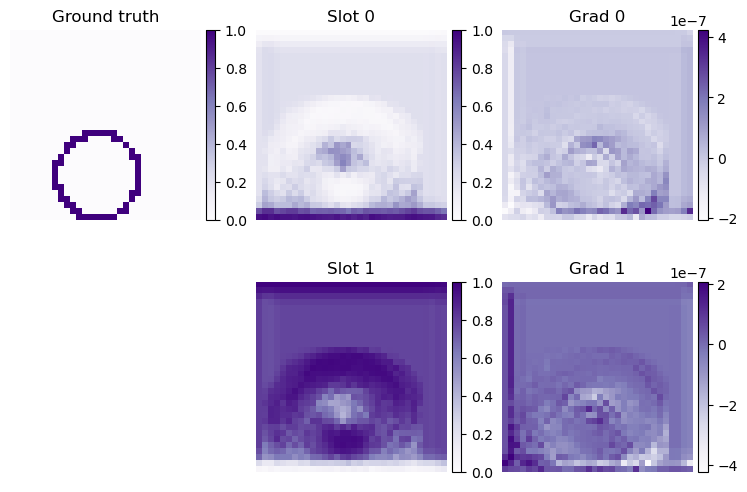

iter 3750 , loss 0.27561873 , lr 0.00029969999999999997


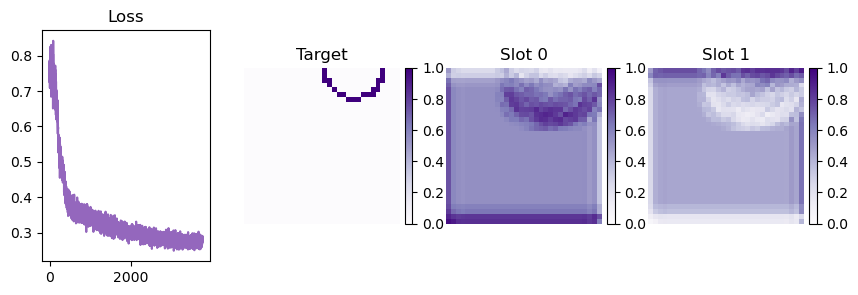

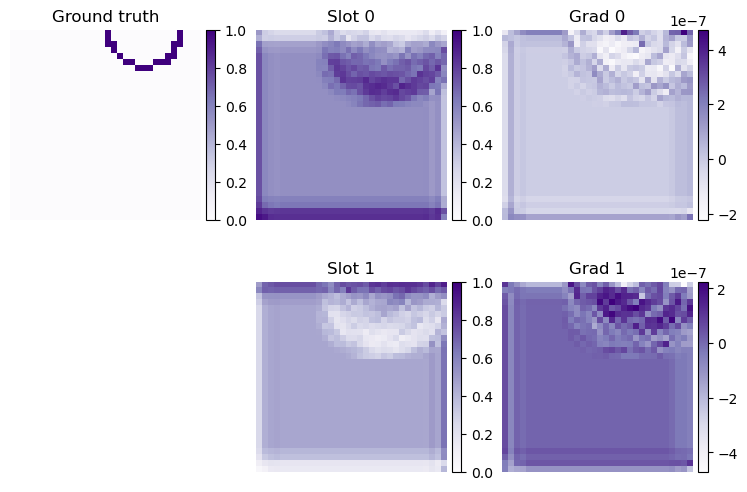

iter 4000 , loss 0.2833861 , lr 0.00029969999999999997


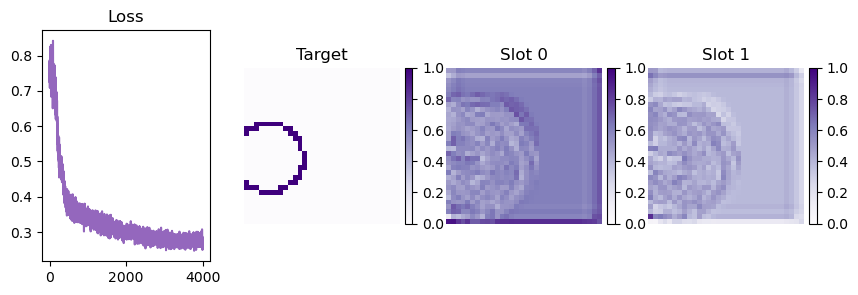

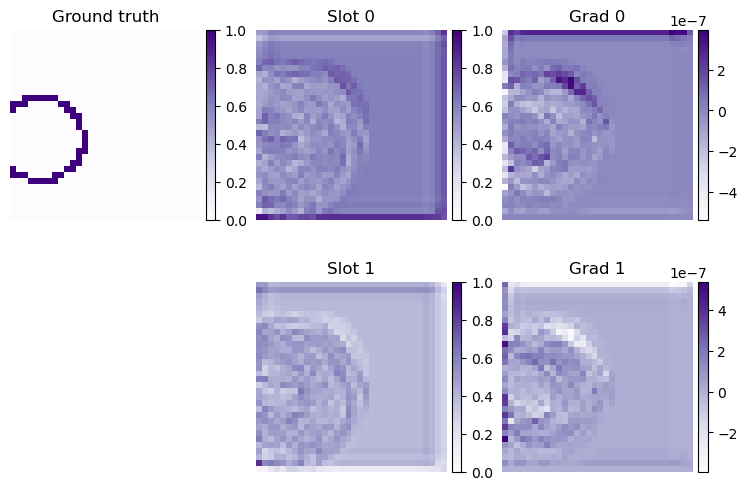

iter 4250 , loss 0.28794563 , lr 0.00029969999999999997


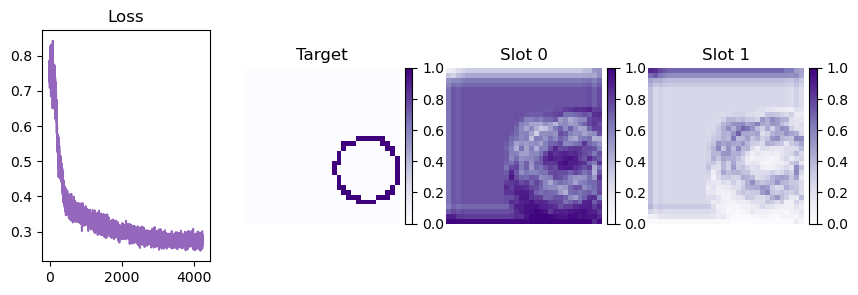

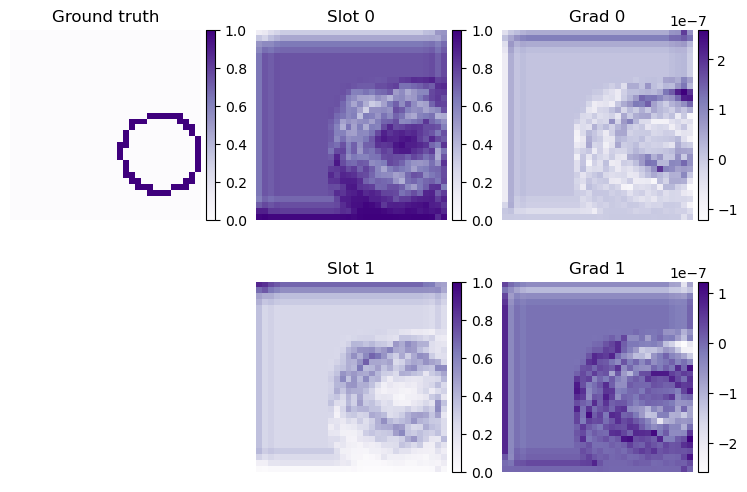

iter 4500 , loss 0.28187597 , lr 0.00029969999999999997


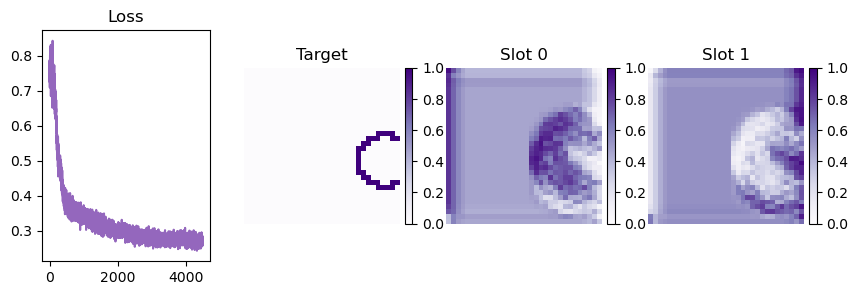

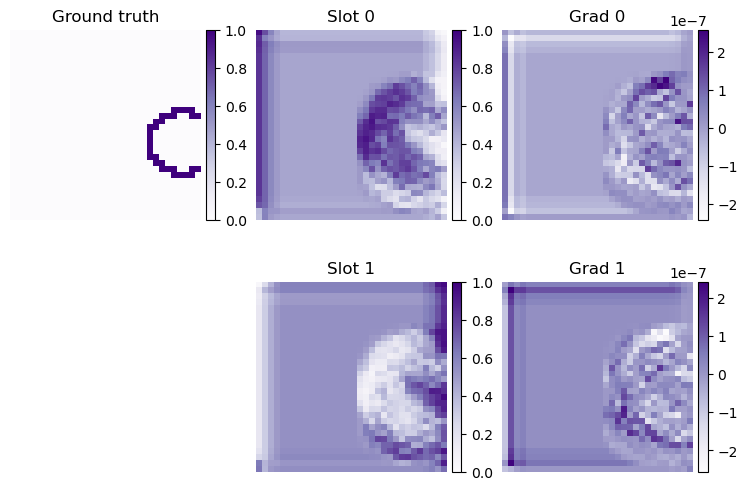

iter 4750 , loss 0.26376027 , lr 0.00029969999999999997


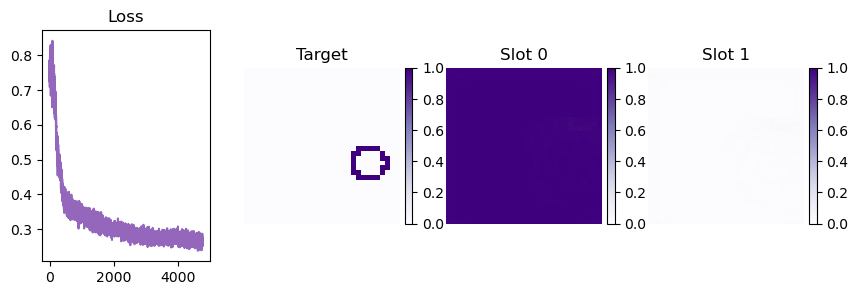

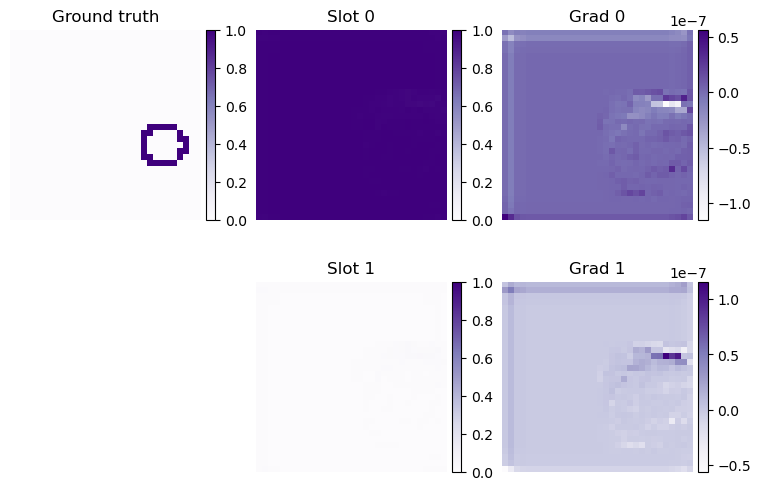

iter 5000 , loss 0.26687676 , lr 0.00029969999999999997


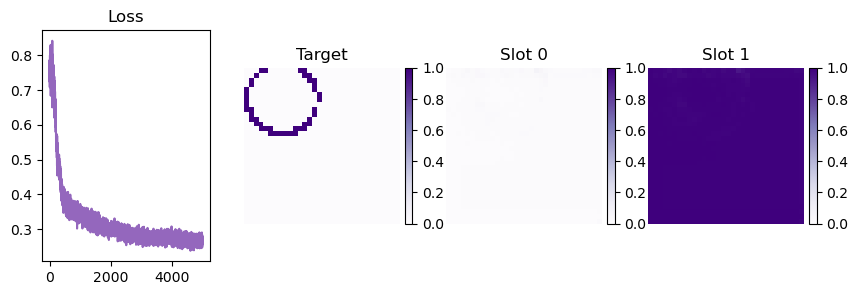

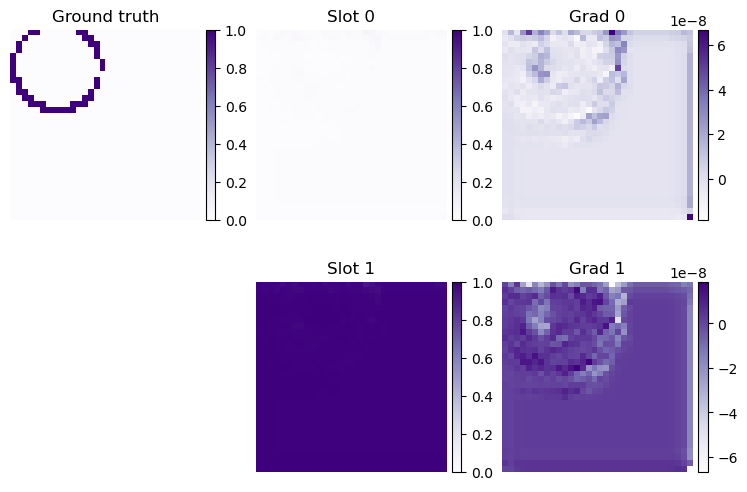

iter 5250 , loss 0.28952986 , lr 0.00029969999999999997


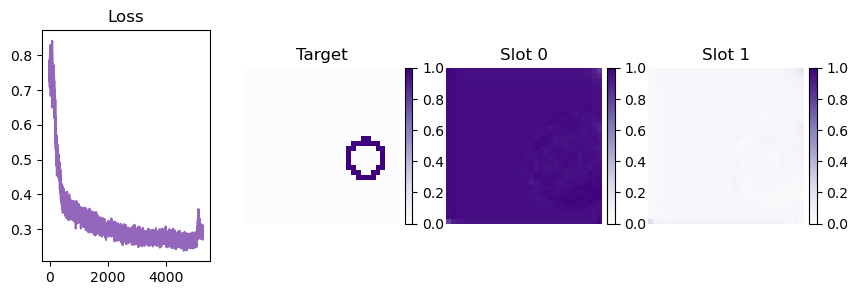

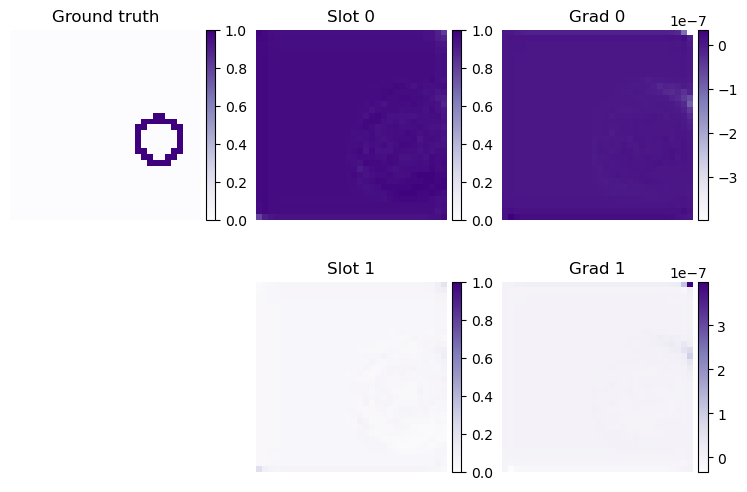

iter 5500 , loss 0.2575104 , lr 0.00029969999999999997


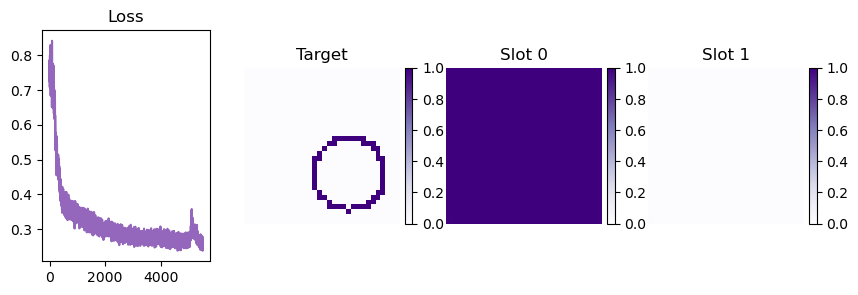

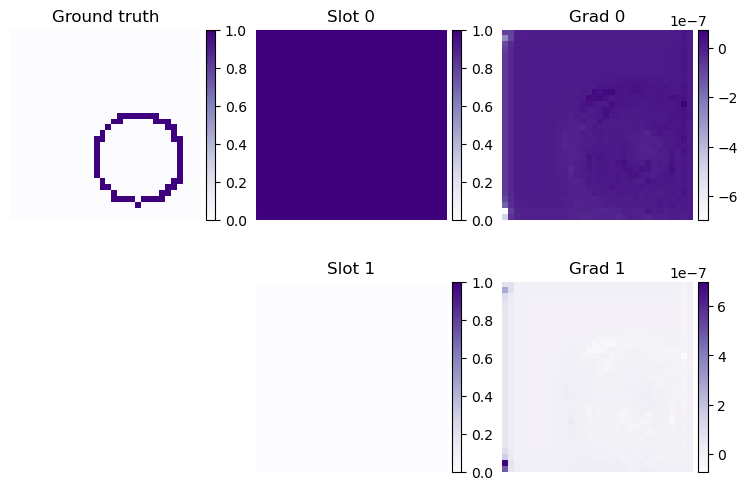

iter 5750 , loss 0.2575344 , lr 0.00029969999999999997


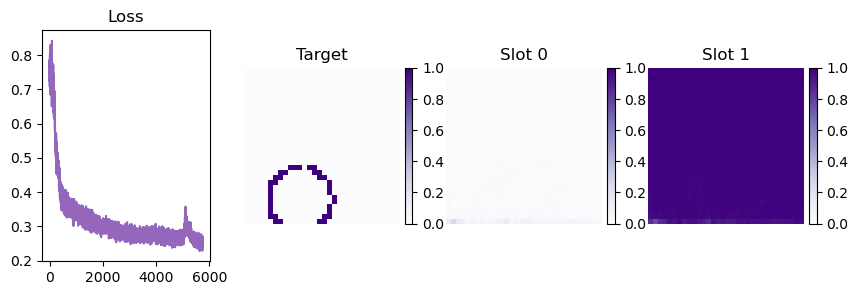

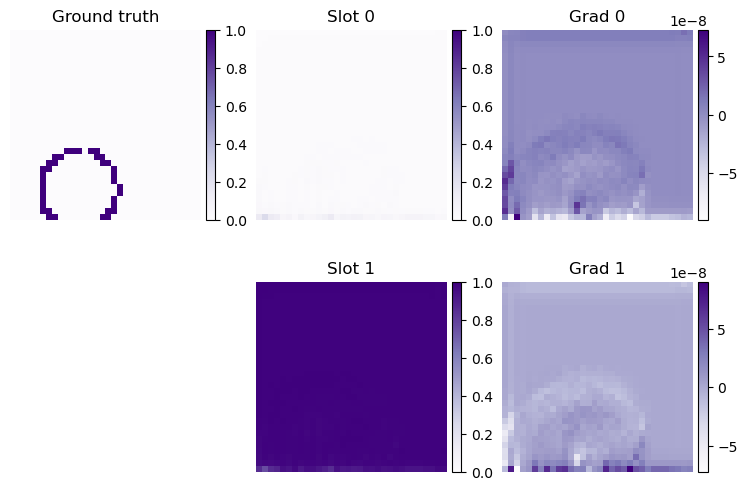

iter 6000 , loss 0.26819485 , lr 0.00029969999999999997


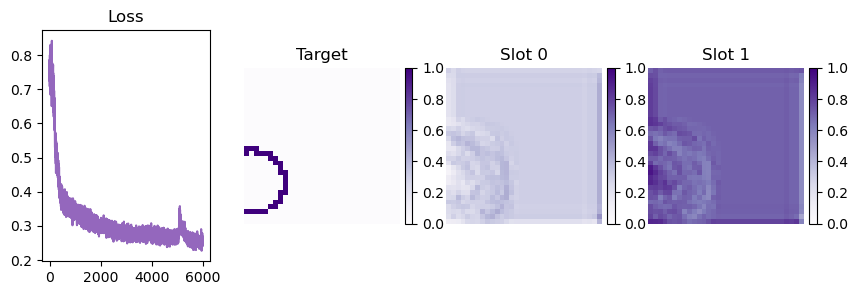

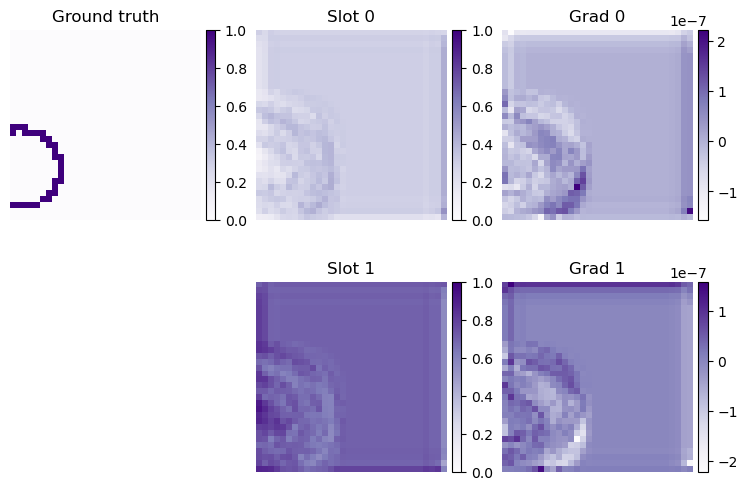

iter 6250 , loss 0.2648812 , lr 0.00029969999999999997


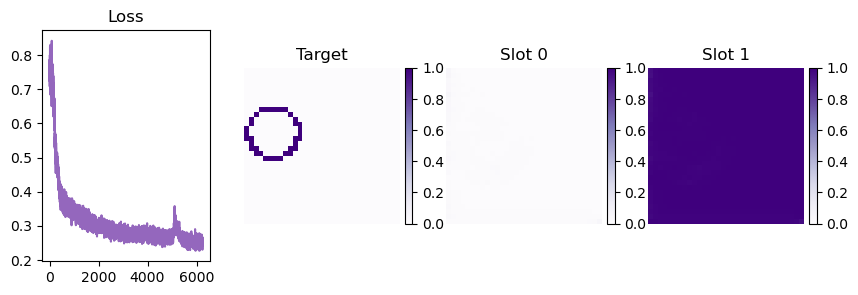

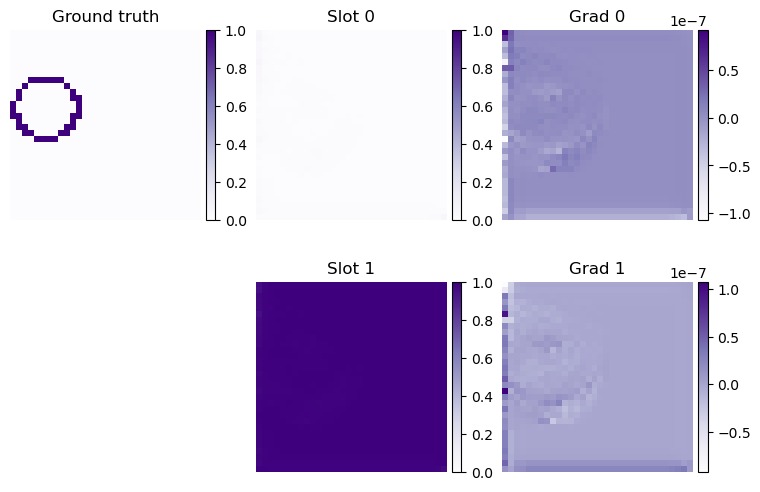

iter 6500 , loss 0.2657486 , lr 0.00029969999999999997


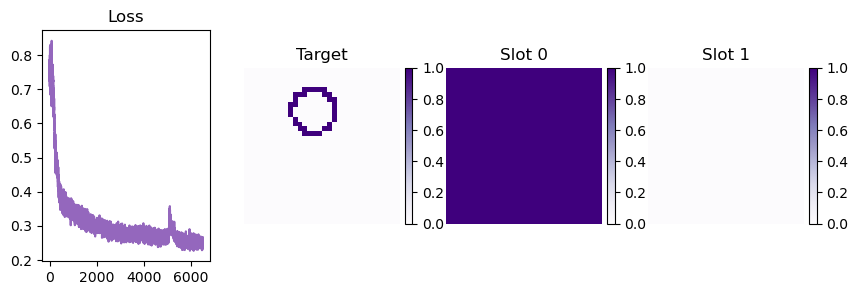

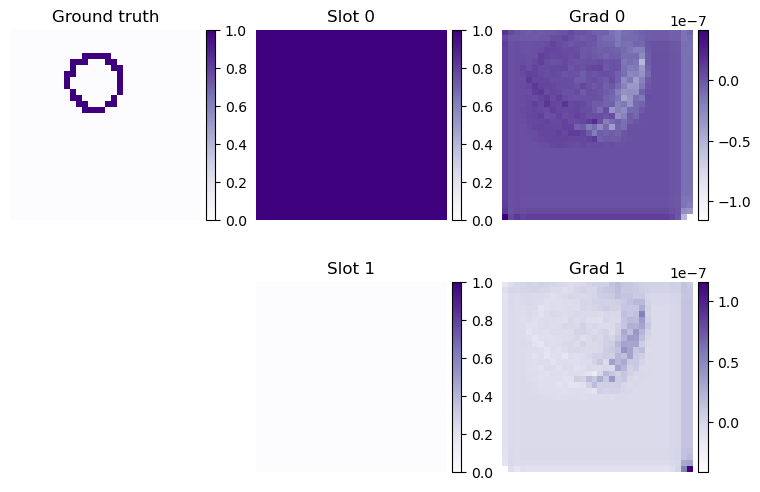

iter 6750 , loss 0.24248633 , lr 0.00029969999999999997


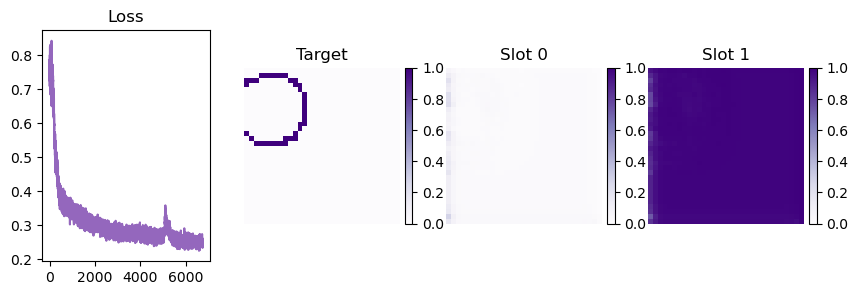

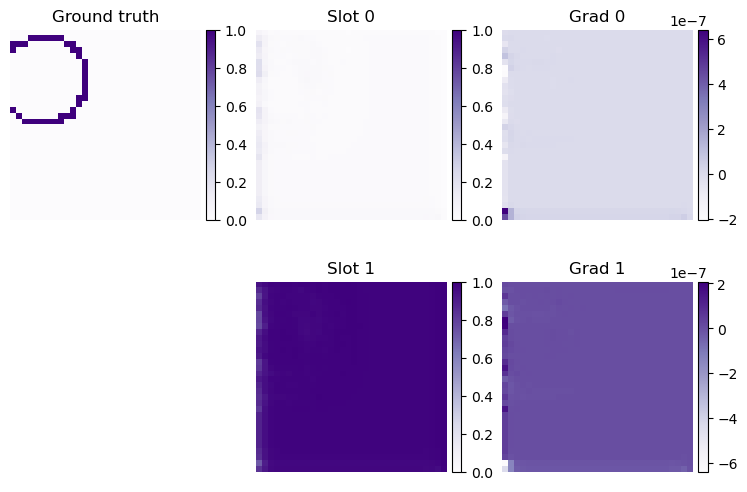

iter 7000 , loss 0.25069603 , lr 0.00029969999999999997


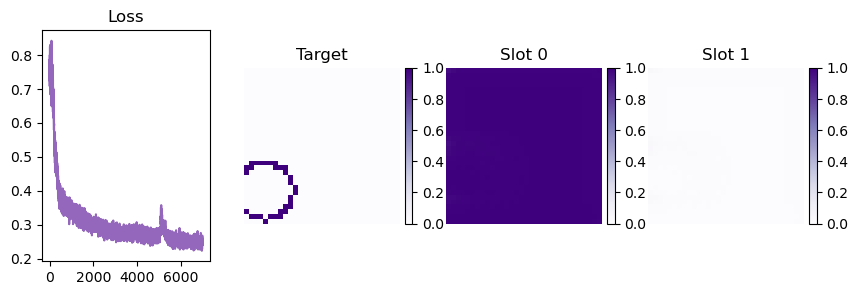

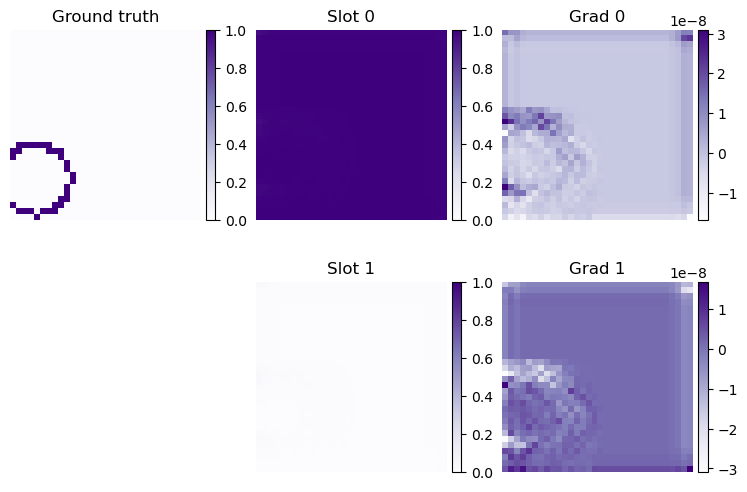

iter 7250 , loss 0.25397888 , lr 0.00029969999999999997


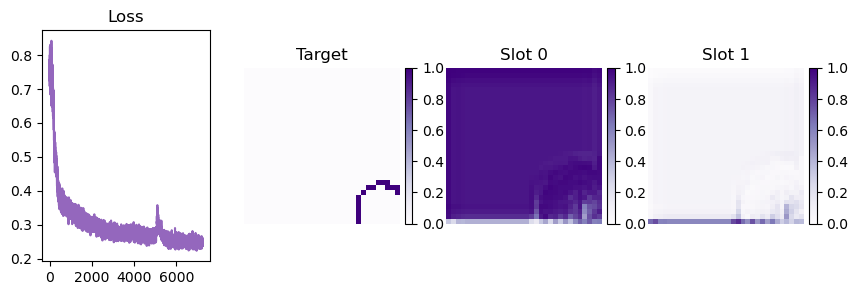

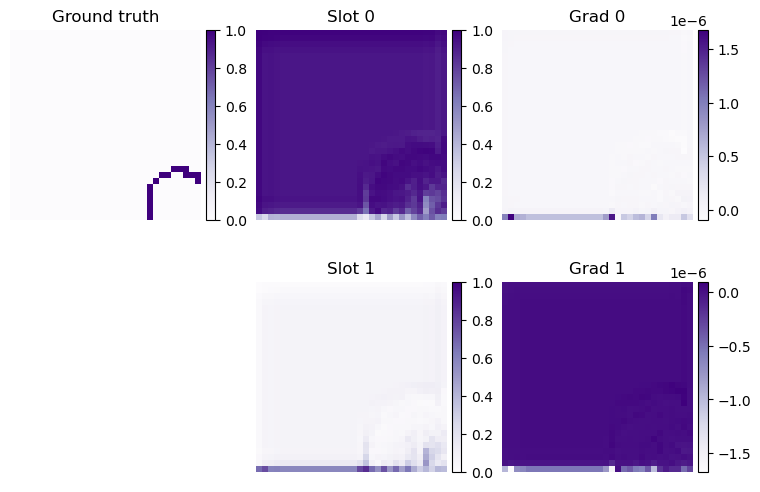

iter 7500 , loss 0.26779872 , lr 0.00029969999999999997


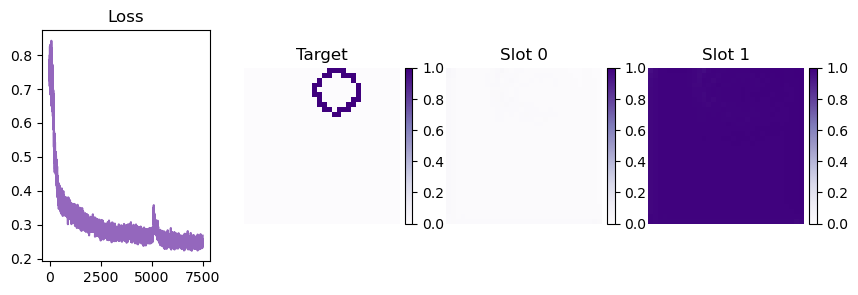

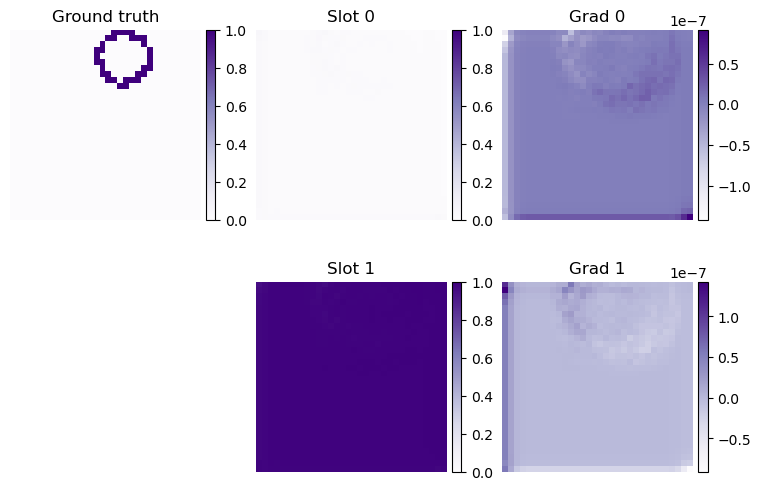

iter 7750 , loss 0.24628398 , lr 0.00029969999999999997


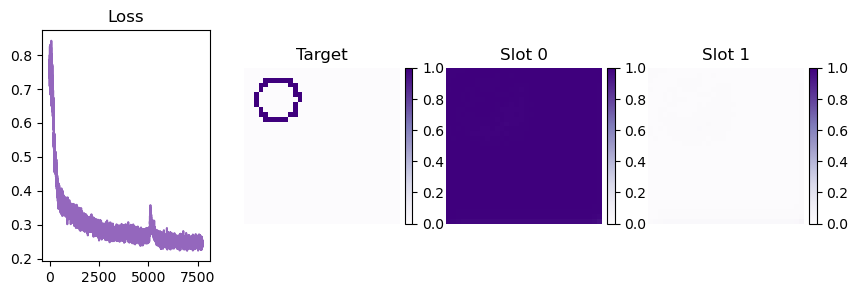

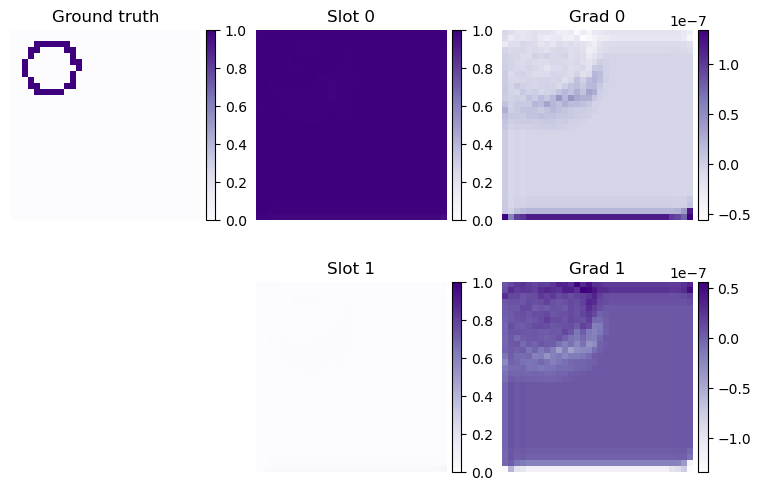

CPU times: user 8min 2s, sys: 49.7 s, total: 8min 52s
Wall time: 28min 34s


In [72]:
%%time

bs = 256
sa,L_wu = train_wu(sa, 8000,bs=bs,device=device, color='C4',cmap="Purples")


**OG try:** I decided to _stop_ the training early, b/c it really wasn't improving, and if I end up doing more of the $\mu$Transfer hp setup, then optimizer schedule didn't seem to be as sensitive of a hyperparameter.

**Follow-up:** the multiplication by 10 was _crucial_ for getting the training to converge!

### 1b) Learning rate decay

**Motivation:** Decrease the _variance_ of the loss funciton

<img src="loss-bs-zoomed.png" style="height:300px"  />



- Let's just train until 8k steps
- Decrease the loss twice in this range?

Official google [repo](https://github.com/nhartman94/google-research/blob/master/slot_attention/set_prediction/train.py#L108-L116)

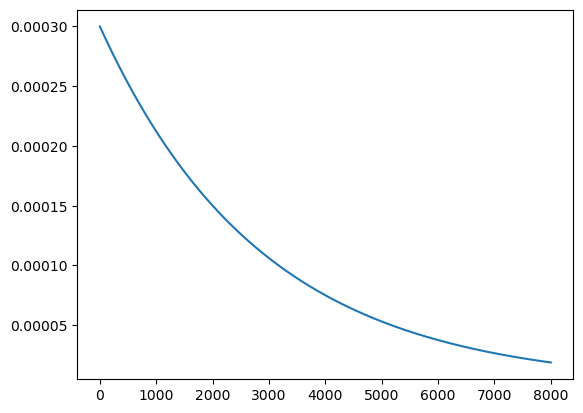

In [38]:
'''
Sanity check the code that I'll put in train()
'''

base_learning_rate = 3e-4
    
decay_rate = 0.5
decay_steps = 2_000

niters = np.arange(8_000)

learning_rate = base_learning_rate * decay_rate ** (niters / decay_steps)

plt.plot(niters,learning_rate)

In [42]:
.5**4

0.0625

In [43]:
learning_rate[-1]/learning_rate[0]

0.06252166460336533

In [165]:
def train(model, Ntrain = 5000, bs=32, device='cpu', color='C0',cmap='Blues'):
    '''
    train
    -----------
    
    - model
    - Ntrain: # of training iterations
    - color,cmap -- options that get passed the
    '''

    # Learning rate schedule config
    base_learning_rate = 3e-4
    
    decay_rate = 0.5
    decay_steps = 2_000
    
    opt = torch.optim.Adam(model.parameters(), base_learning_rate)
    model.train()
    losses = []
    
    for i in range(Ntrain):

        learning_rate = base_learning_rate * decay_rate ** (i / decay_steps)
        
        opt.param_groups[0]['lr'] = learning_rate
        
        X, Y, mask = make_batch(bs,device)
        
        queries, att = model(X)
            
        loss = hungarian_bce_one_ring(att,mask,bs=bs)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        losses.append(float(loss))
        
        if i % 250 == 0:
            print('iter',i,', loss',loss.detach().cpu().numpy(),', lr',opt.param_groups[0]['lr'])
            
            iEvt = 0
            att_img = att[iEvt].reshape(model.k_slots,nPixels,nPixels)
            plot_2slots_1ring(losses, 
                              mask[iEvt,0].detach().cpu().numpy(), 
                              att_img.detach().cpu().numpy(),
                              color=color,cmap=cmap)

#             plotAttnMapsGrads(model,mask,att,iEvt,cmap)
            
    model.eval()
    return model,losses

iter 0 , loss 0.62795687 , lr 0.0003


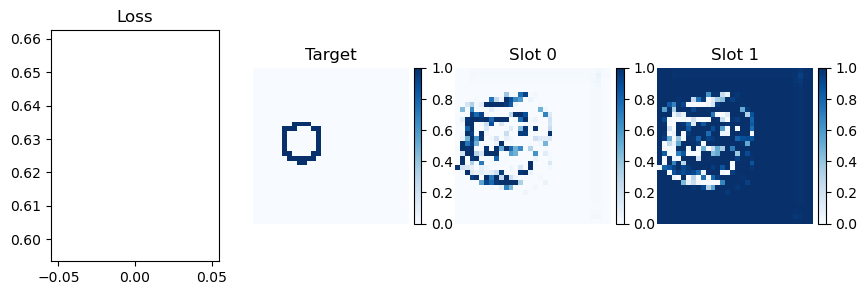

iter 250 , loss 0.23083284 , lr 0.0002751012129614013


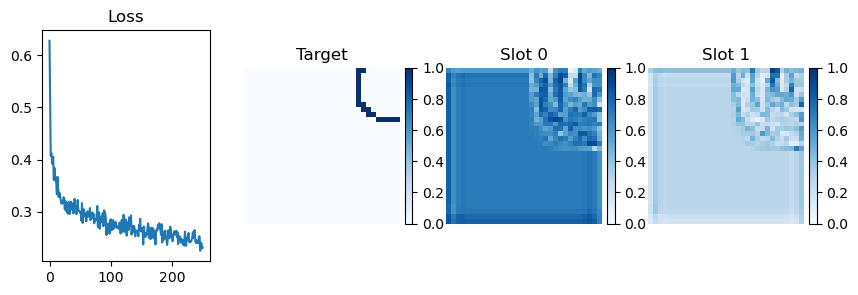

iter 500 , loss 0.10979445 , lr 0.00025226892457611434


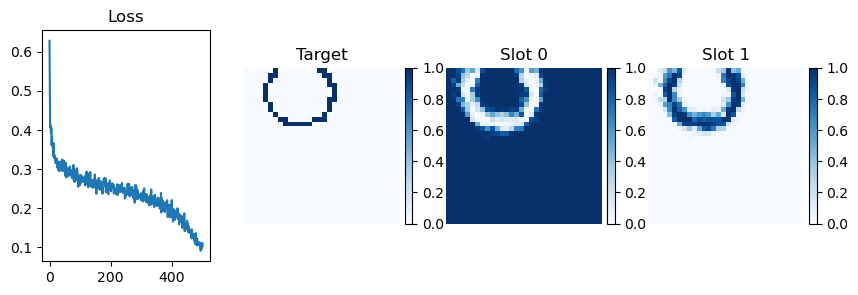

iter 750 , loss 0.03052377 , lr 0.00023133162381119108


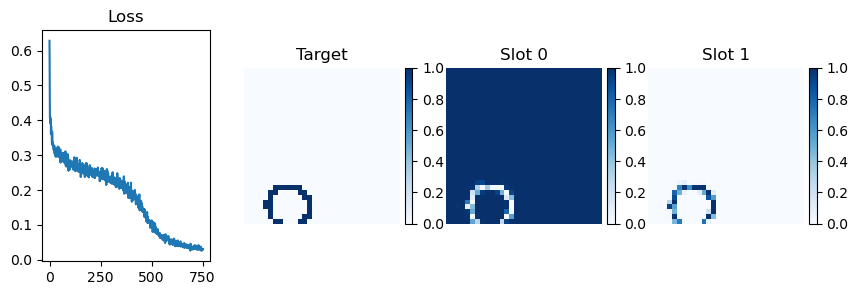

iter 1000 , loss 0.029511716 , lr 0.00021213203435596425


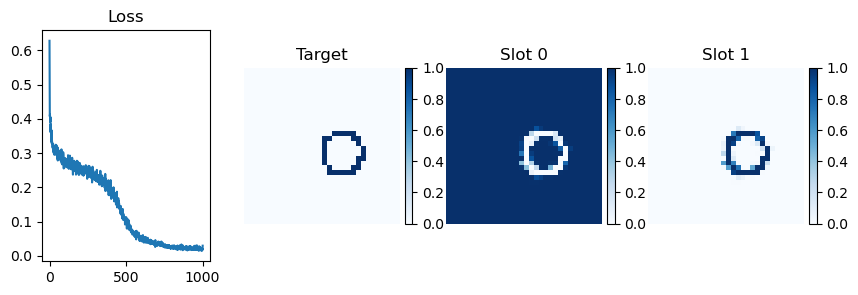

iter 1250 , loss 0.011951913 , lr 0.00019452593319765142


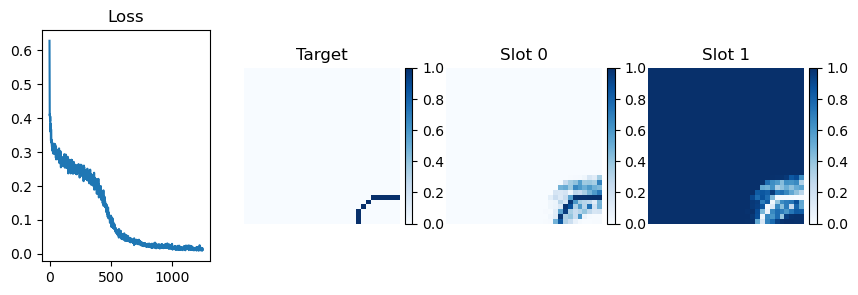

iter 1500 , loss 0.009342905 , lr 0.00017838106725040815


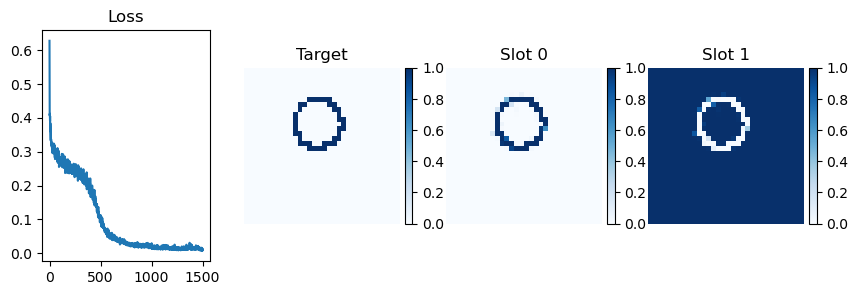

iter 1750 , loss 0.0063502826 , lr 0.00016357615989978863


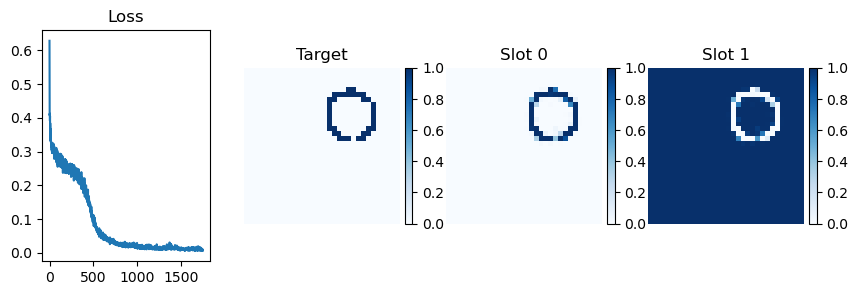

iter 2000 , loss 0.0076115313 , lr 0.00015


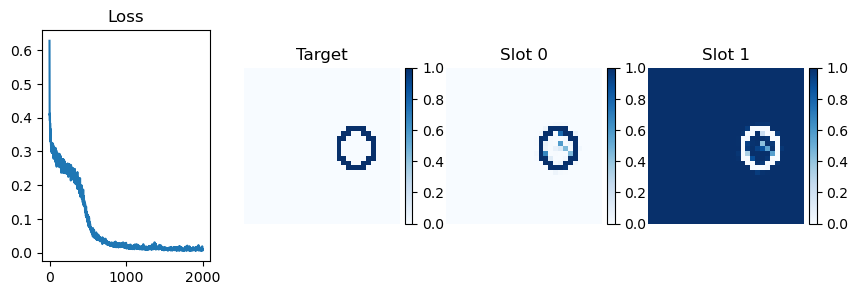

iter 2250 , loss 0.009889899 , lr 0.00013755060648070066


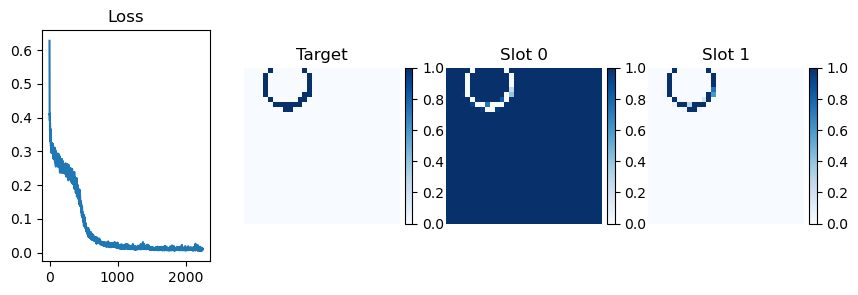

iter 2500 , loss 0.0063250954 , lr 0.00012613446228805717


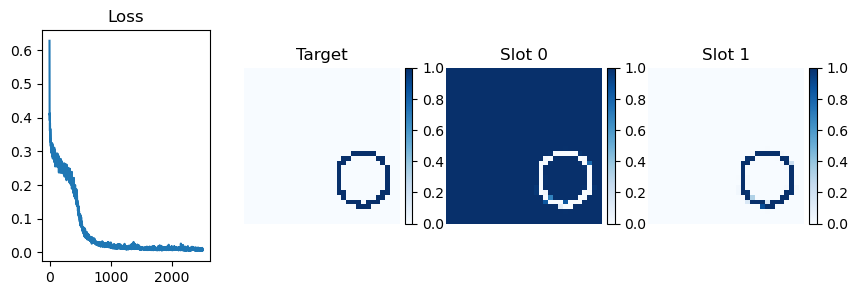

iter 2750 , loss 0.0108442865 , lr 0.00011566581190559554


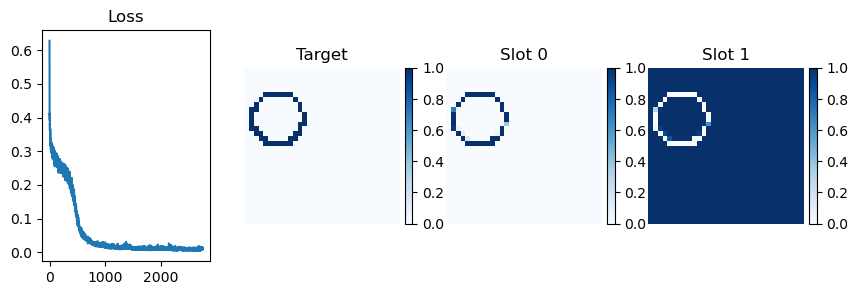

iter 3000 , loss 0.014770309 , lr 0.00010606601717798212


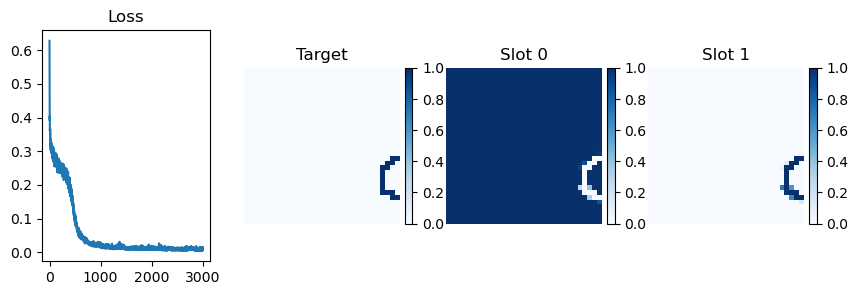

iter 3250 , loss 0.012450088 , lr 9.726296659882571e-05


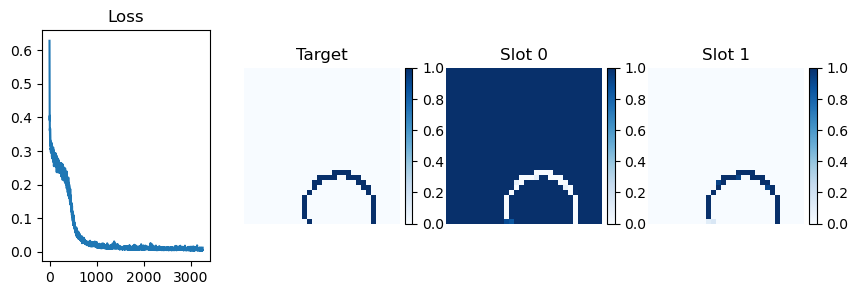

iter 3500 , loss 0.0043694987 , lr 8.919053362520407e-05


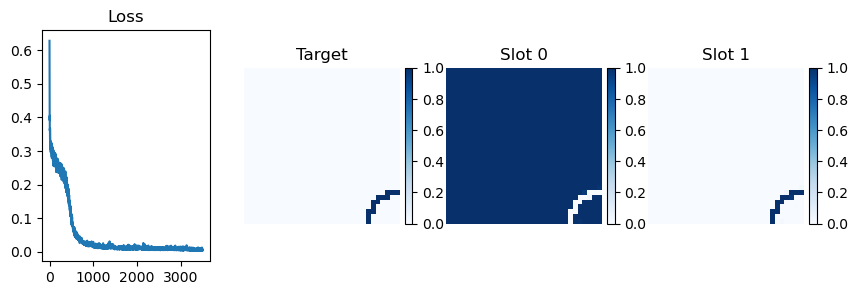

iter 3750 , loss 0.0075275553 , lr 8.178807994989432e-05


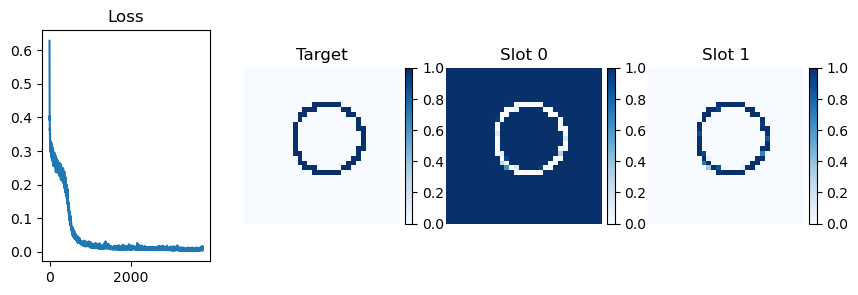

iter 4000 , loss 0.0035417527 , lr 7.5e-05


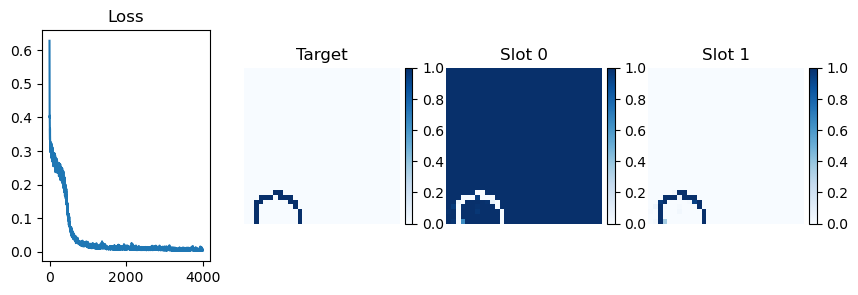

iter 4250 , loss 0.0034832172 , lr 6.877530324035033e-05


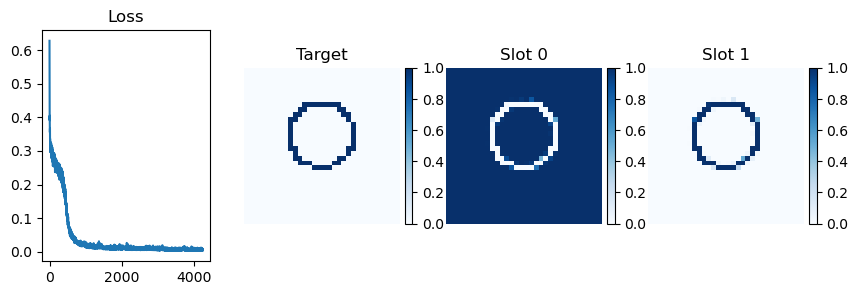

iter 4500 , loss 0.006526549 , lr 6.306723114402858e-05


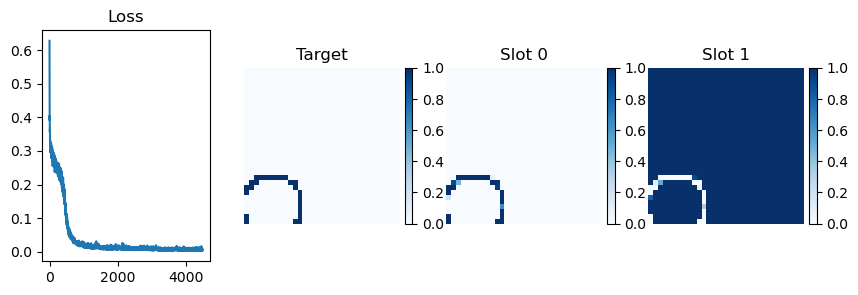

iter 4750 , loss 0.004315461 , lr 5.783290595279777e-05


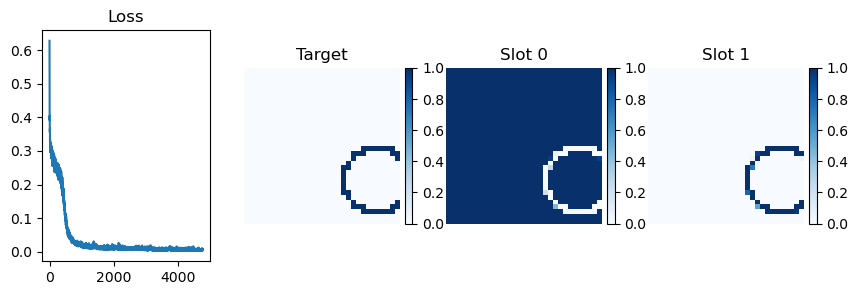

iter 5000 , loss 0.005485292 , lr 5.303300858899106e-05


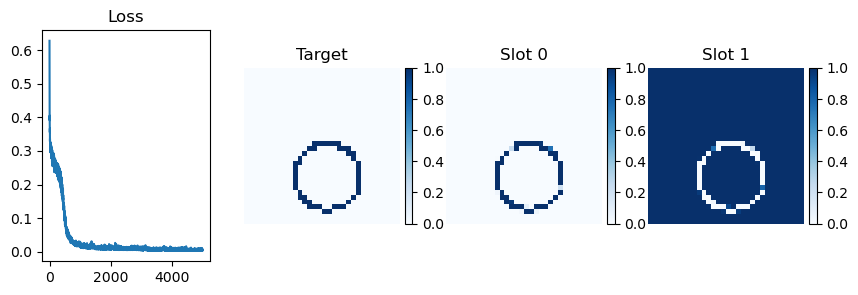

iter 5250 , loss 0.0036699362 , lr 4.8631483299412856e-05


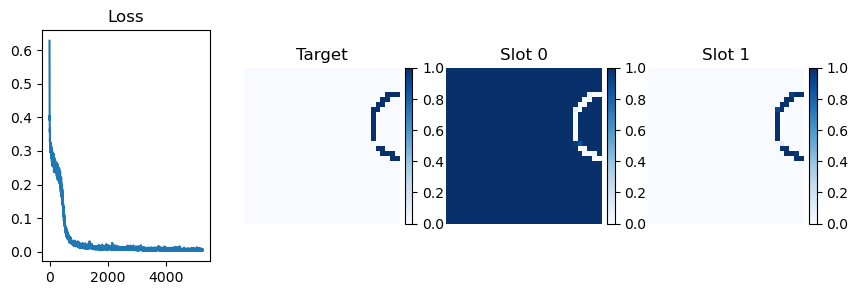

iter 5500 , loss 0.0066803168 , lr 4.459526681260204e-05


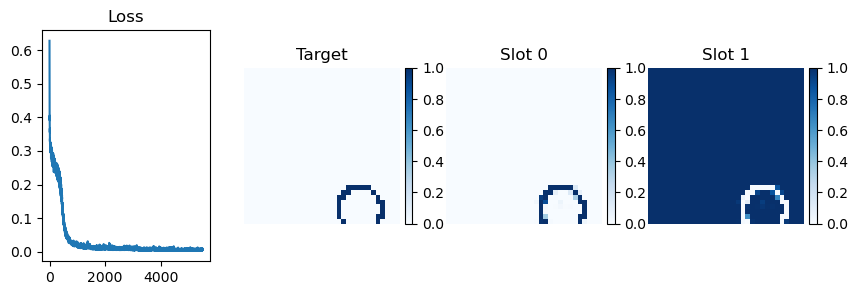

iter 5750 , loss 0.003136988 , lr 4.089403997494716e-05


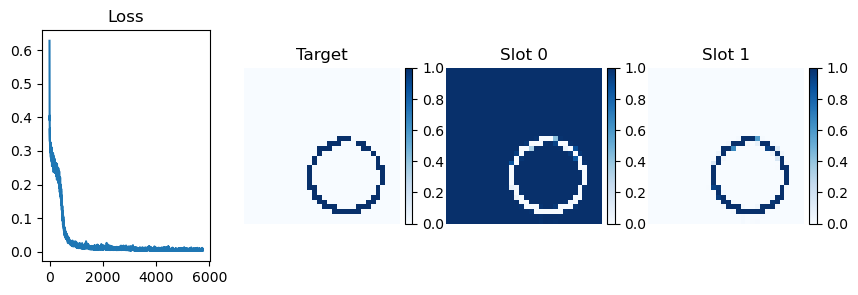

iter 6000 , loss 0.0044507124 , lr 3.75e-05


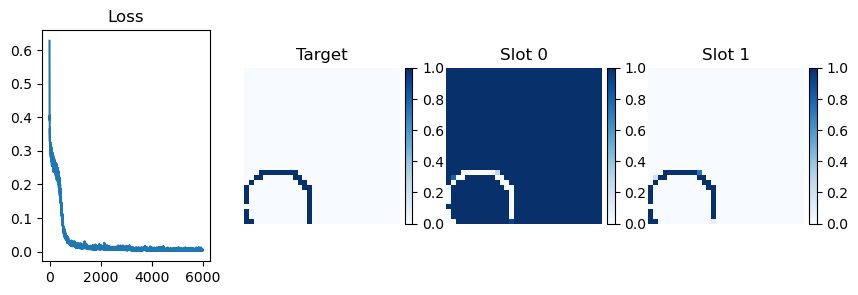

iter 6250 , loss 0.004242307 , lr 3.4387651620175164e-05


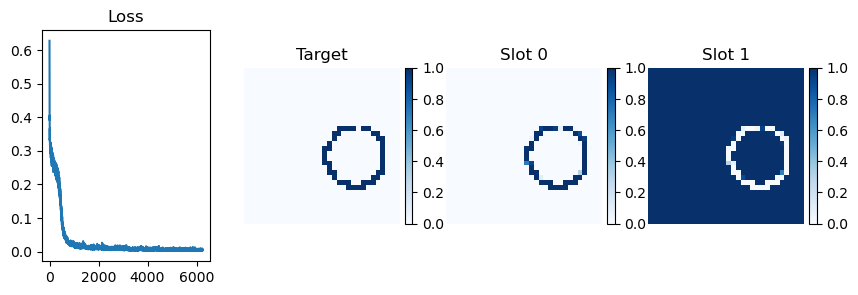

iter 6500 , loss 0.0037689845 , lr 3.153361557201429e-05


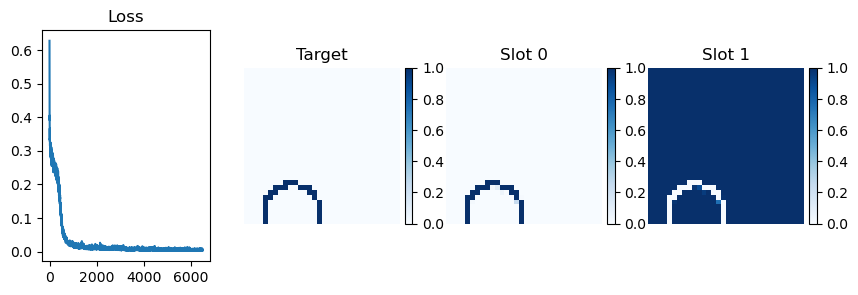

iter 6750 , loss 0.002656666 , lr 2.8916452976398885e-05


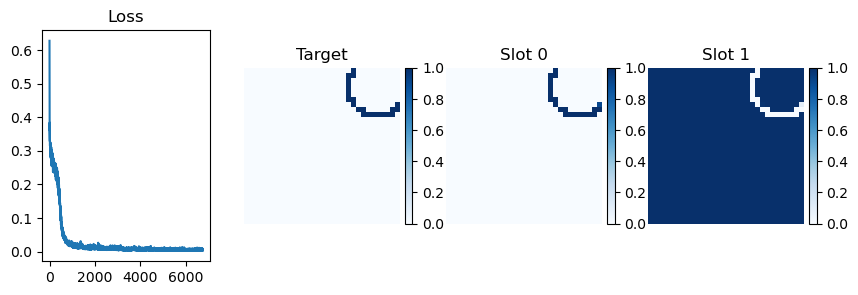

iter 7000 , loss 0.0037355856 , lr 2.651650429449553e-05


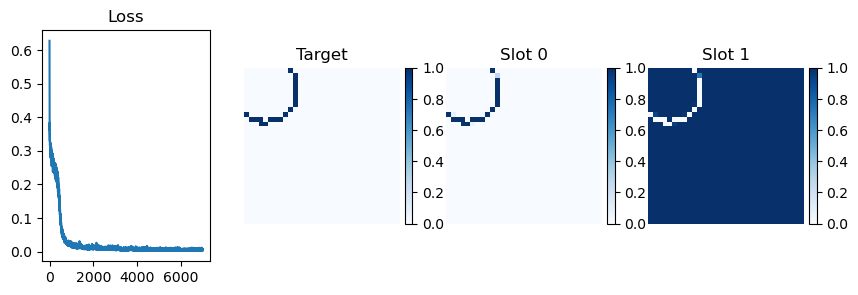

iter 7250 , loss 0.0047919527 , lr 2.4315741649706428e-05


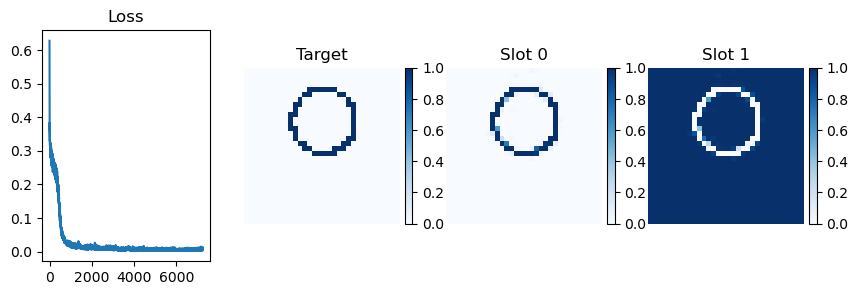

iter 7500 , loss 0.0047236914 , lr 2.229763340630102e-05


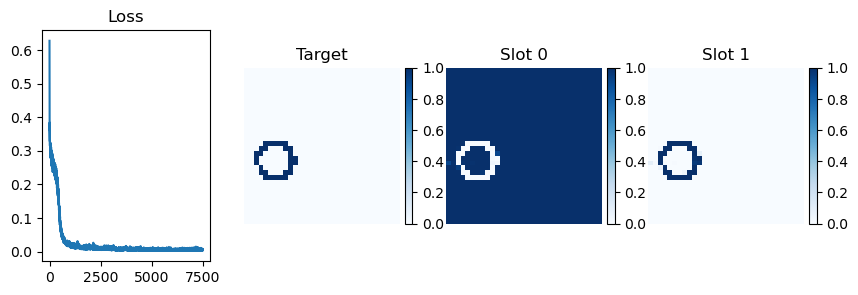

iter 7750 , loss 0.004990212 , lr 2.044701998747358e-05


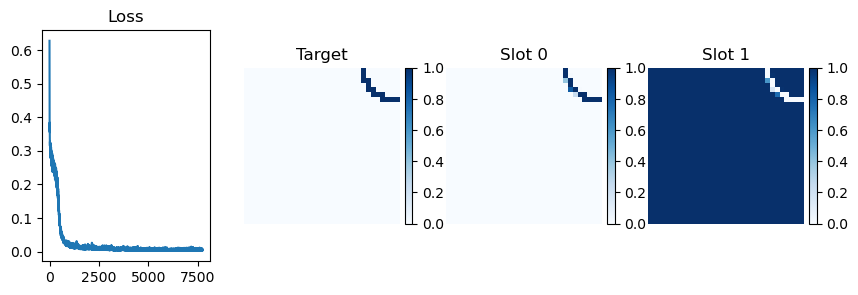

In [60]:
bs = 256
device='cpu'

sa_decay = SlotAttentionMini(k_slots=2,device=device).to(device)

sa_decay,L_de = train(sa_decay, 8_000,bs=bs,device=device, color='C0',cmap="Blues")

[0.6279568672180176,
 0.510483980178833,
 0.40711939334869385,
 0.41246646642684937,
 0.3992311954498291,
 0.3911331593990326,
 0.4052108824253082,
 0.36080503463745117,
 0.38420504331588745,
 0.36703693866729736,
 0.3591444492340088,
 0.3553611636161804,
 0.3332263231277466,
 0.36692020297050476,
 0.3460969924926758,
 0.32823479175567627,
 0.3365638554096222,
 0.3322959840297699,
 0.3241657614707947,
 0.31694459915161133,
 0.31513598561286926,
 0.3154042065143585,
 0.32173168659210205,
 0.3275589048862457,
 0.3252415359020233,
 0.3041233420372009,
 0.3204142451286316,
 0.3084234893321991,
 0.29970288276672363,
 0.3130955696105957,
 0.2960701882839203,
 0.31859004497528076,
 0.30355051159858704,
 0.2956140637397766,
 0.31392472982406616,
 0.31910985708236694,
 0.3059033453464508,
 0.30306440591812134,
 0.31589218974113464,
 0.2966635823249817,
 0.3059872090816498,
 0.3243335783481598,
 0.30683448910713196,
 0.3105185627937317,
 0.2949918806552887,
 0.3005884885787964,
 0.32223948836326

# 3 Positional embedding


OK, 3 options:
1. No positional embedding
2. LH's positional embedding
3. SA paper positional embedding

Let's train these models with _weight decay_ now, as I think it leads to ~ more 

In [77]:
from model import build_grid

In [80]:
?build_grid

In [82]:
grid = build_grid()

In [86]:
np.prod((nPixels,nPixels))

1024

In [88]:
grid.shape

(1, 32, 32, 4)

In [99]:
X.shape

torch.Size([2, 1, 32, 32])

In [112]:
posEnc = SoftPositionalEmbed(hidden_dim=16,resolution=(nPixels,nPixels))

In [140]:
x = torch.rand(2,32,32,16)
x.shape

torch.Size([2, 32, 32, 16])

In [142]:
out = posEnc(x)

In [143]:
out.shape

torch.Size([2, 32, 32, 16])

In [134]:
# sa_pe = SlotAttentionPosEmbed(device=device,hidden_dim=64).to(device)

In [131]:
out = sa_pe(X)

encoded_data torch.Size([2, 64, 32, 32])


In [137]:
posEnc = SoftPositionalEmbed(16, (nPixels, nPixels))

In [139]:
posEnc.dense(posEnc.grid).shape

torch.Size([1, 32, 32, 16])

In [166]:
class SoftPositionalEmbed(torch.nn.Module):
    def __init__(self,hidden_dim,resolution,device='cpu'):
        '''
        Given the dimensions of the input image, this layer adds 
        a residual connection for a _learnable projection_ of the
        grid of the (normalized) positions of the input image.
        
        - hidden_dim: The # of channels that the input image has
        - resolution: A tuple of the width and height of the input image.
        
        Translated into pytorch from google's tf fct:
        https://github.com/nhartman94/google-research/blob/master/slot_attention/model.py#L367-L382
        
        '''
        super().__init__()
        
        self.dense = torch.nn.Linear(4, hidden_dim)
        
        grid = build_grid(resolution)
        self.grid = torch.FloatTensor( grid ).to(device)
        
    def forward(self, x):
        
        return x + self.dense(self.grid)

In [167]:
class SlotAttentionPosEmbed(torch.nn.Module):
    def __init__(self, 
                 resolution=(32,32),
                 k_slots=3, 
                 hidden_dim=32, 
                 query_dim=32, 
                 n_iter=2,
                 device='cpu', 
                 ):
        '''
        Slot attention encoder block

        Inputs:
        - device (cpu, mps, cuda): Which device to put the model on 
                (needed for the random call when initializing the slots)
        - k_slots: number of slots (note, can vary between training and test time)
        - hidden_dim: The hidden dimension for the CNN (currently single layer w/ no non-linearities)
        - query_dim: The latent space dimension that the slots and the queries get computed in
        - n_iter: Number of slot attention steps to apply (defualt 2, and rn hard coded)
        '''
        super().__init__()

        self.k_slots = k_slots
        self.hidden_dim = hidden_dim
        self.query_dim = query_dim
        self.n_iter = n_iter

        self.device=device
        
        self.dataN = torch.nn.LayerNorm(self.hidden_dim)
        self.queryN = torch.nn.LayerNorm(self.query_dim)
        
        self.toK = torch.nn.Linear(self.hidden_dim, self.query_dim)
        self.toV = torch.nn.Linear(self.hidden_dim, self.query_dim)
        self.gru = torch.nn.GRUCell(self.query_dim, self.query_dim)

        filter_size=5
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1,self.hidden_dim,filter_size, padding = 2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(self.hidden_dim,self.hidden_dim,filter_size, padding = 2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(self.hidden_dim,self.hidden_dim,filter_size, padding = 2),
        )
        
        # I think _in theory_ this is where the positional embedding should go too
        self.posEnc = SoftPositionalEmbed(hidden_dim, resolution,device)
        
    def init_slots(self, Nbatch):
        noise = torch.randn(Nbatch, self.k_slots, self.query_dim).to(self.device)
        
        mu = torch.zeros(1,1,self.query_dim).to(self.device)
        logsigma = torch.zeros(1,1,self.query_dim).to(self.device)
        
        return mu + noise*logsigma.exp()
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
            
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    def attention_and_weights(self,queries,encoded_data):
        keys = self.toK(encoded_data)
        logits = torch.einsum('bse,bde->bsd',queries,keys) * (self.query_dim ** (-0.5)) * 10
        
        if logits.requires_grad:
            h = logits.register_hook(self.activations_hook)
        
        att = torch.nn.functional.softmax(logits, dim = 1)

        div = torch.sum(att, dim = -1, keepdims = True)
        wts = att/div + 1e-8
        return att,wts

    def iterate(self, queries, encoded_data):
        
        # queries: (bs, n_slots, query_dim)
        
        att,wts = self.attention_and_weights(self.queryN(queries),encoded_data)   
        
        # att: (bs, n_slots, img_dim)
        # wts: (bs, n_slots, img_dim)
        
        vals = self.toV(encoded_data) # bs, img_dim, query_dim
        updates = torch.einsum('bsd,bde->bse',wts,vals) # bs, n_slots, query_dim
        
        updates = self.gru(
            updates.reshape(-1,self.query_dim),
            queries.reshape(-1,self.query_dim),
        )

        return updates.reshape(queries.shape)
        
    def forward(self, data):

        Nbatch = data.shape[0]
        
        # Initialize the queries
        queries = self.init_slots(Nbatch) # Shape (Nbatch, query_dim)
        
        # Apply the CNN encoder
        encoded_data = self.encoder(data)
        
        # Put the channel dim at the end
        encoded_data = torch.permute(encoded_data,(0,2,3,1)) 
                 
        # Add the positional embeddings
        encoded_data = self.posEnc(encoded_data)
       
        # Flatten the pixel dims and apply the data normalization
        encoded_data = torch.flatten(encoded_data,1,2)
        encoded_data = self.dataN(encoded_data)
    
        for i in range(self.n_iter):
            queries = self.iterate(queries, encoded_data)    
            
        # Then with the _final_ query vector, calc what the attn + weights would be
        att, wts = self.attention_and_weights(self.queryN(queries),encoded_data)   
            
        return queries, att #.reshape(-1,self.k_slots,nPixels,nPixels)
        

In [168]:
device

device(type='mps')

iter 0 , loss 0.52770334 , lr 0.0003


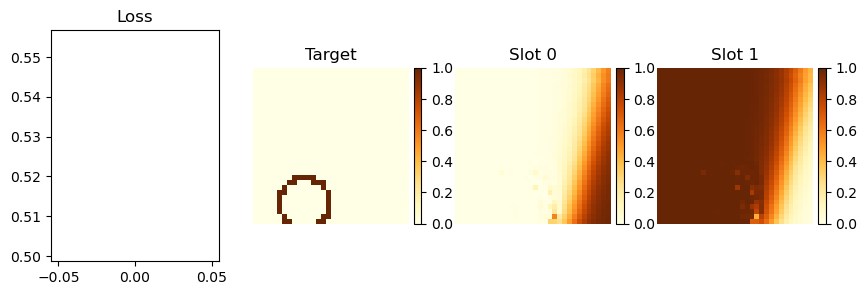

iter 250 , loss 0.3217649 , lr 0.0002751012129614013


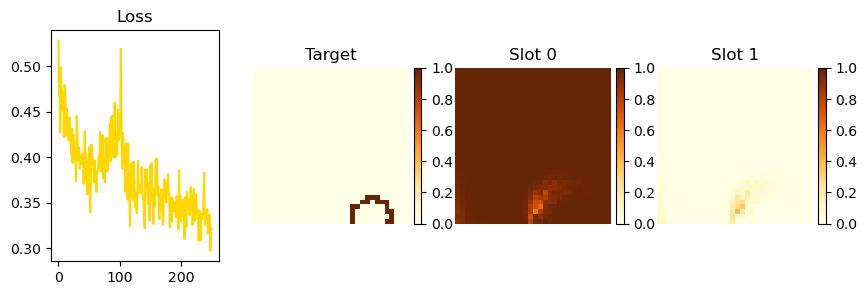

iter 500 , loss 0.2661987 , lr 0.00025226892457611434


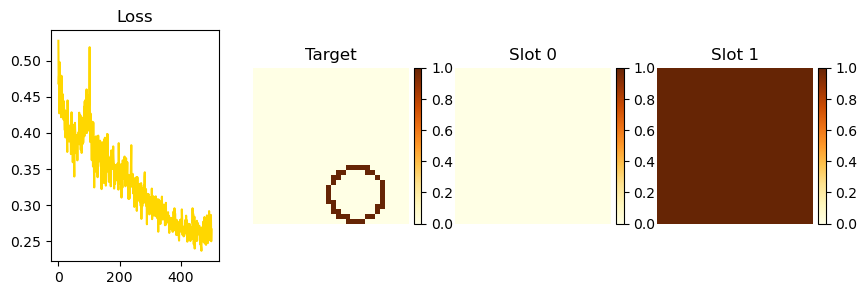

iter 750 , loss 0.2382372 , lr 0.00023133162381119108


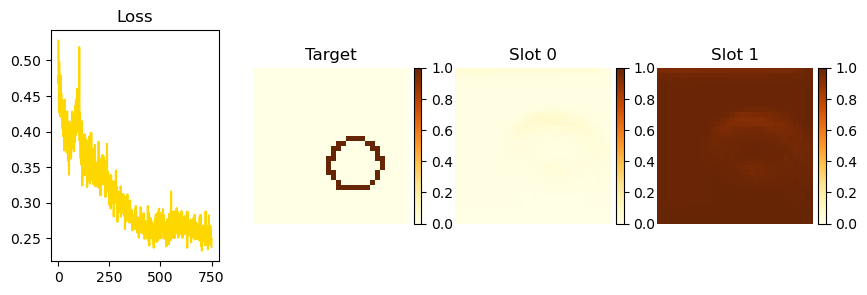

iter 1000 , loss 0.266752 , lr 0.00021213203435596425


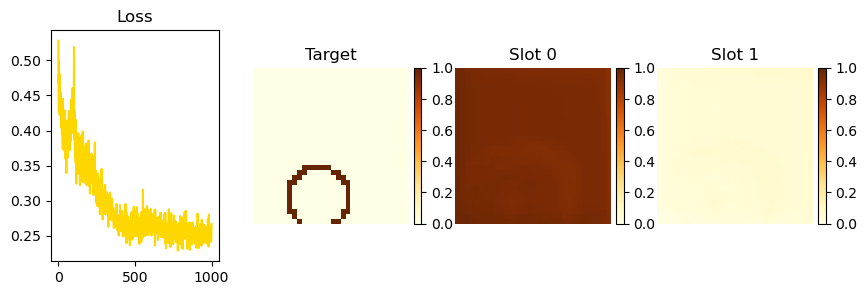

iter 1250 , loss 0.23192841 , lr 0.00019452593319765142


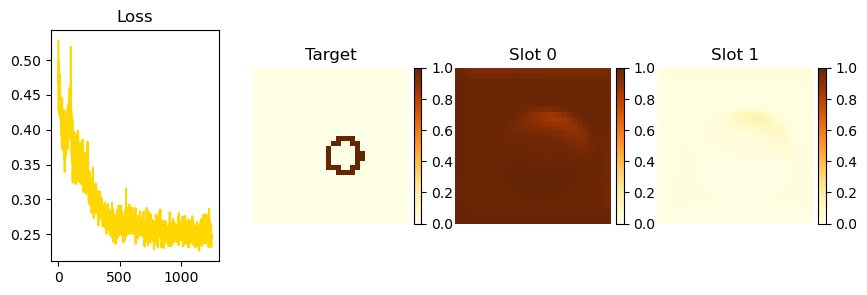

iter 1500 , loss 0.25880527 , lr 0.00017838106725040815


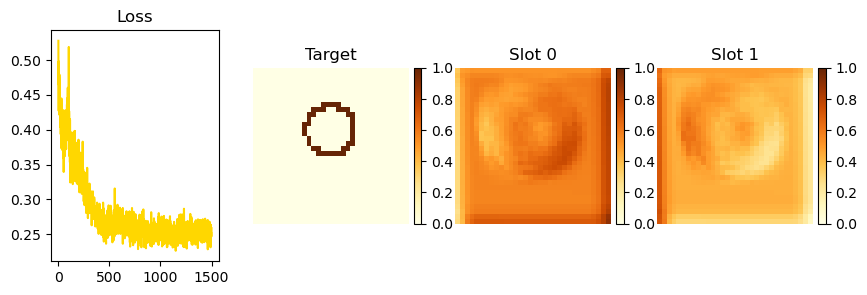

iter 1750 , loss 0.25910595 , lr 0.00016357615989978863


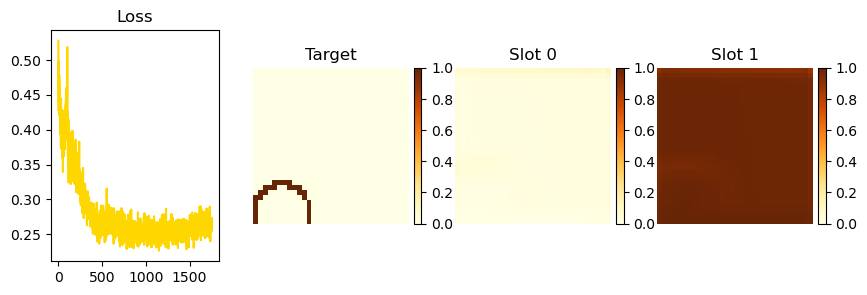

iter 2000 , loss 0.26979977 , lr 0.00015


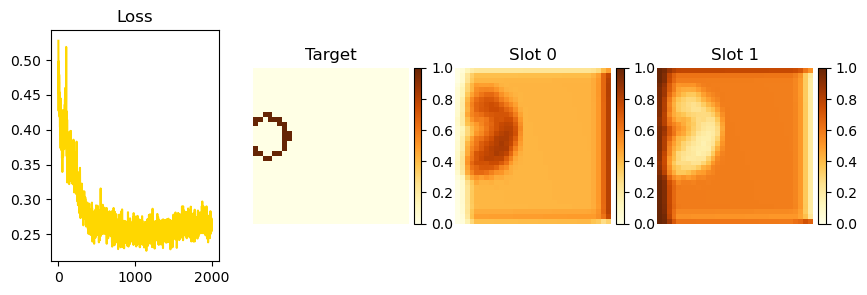

iter 2250 , loss 0.2687499 , lr 0.00013755060648070066


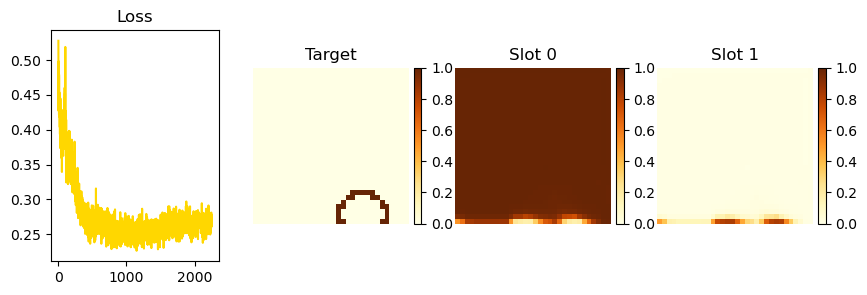

iter 2500 , loss 0.2546845 , lr 0.00012613446228805717


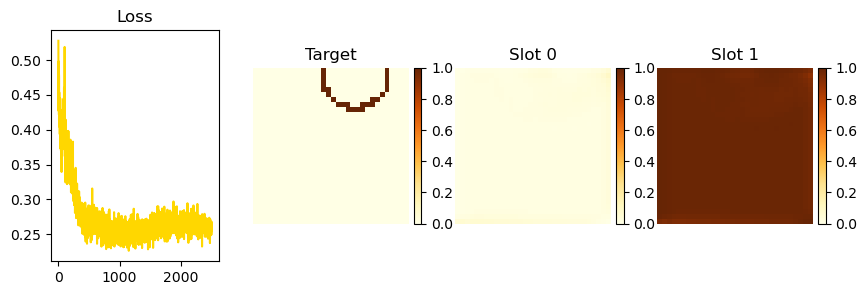

iter 2750 , loss 0.2525319 , lr 0.00011566581190559554


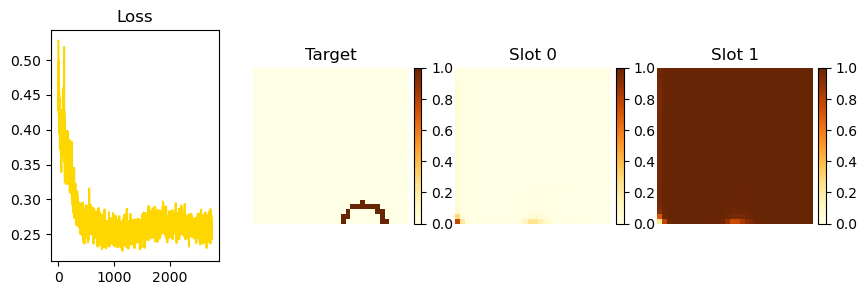

iter 3000 , loss 0.23737633 , lr 0.00010606601717798212


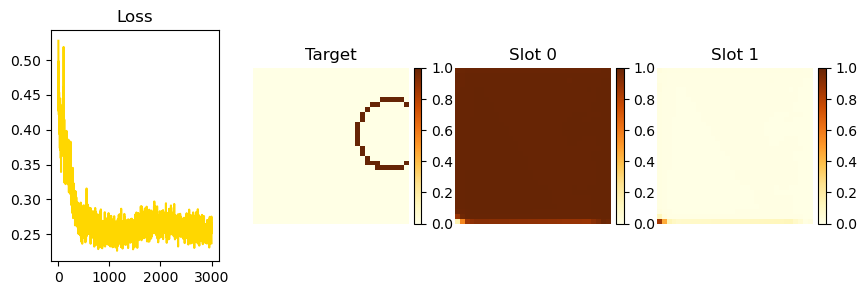

iter 3250 , loss 0.2656537 , lr 9.726296659882571e-05


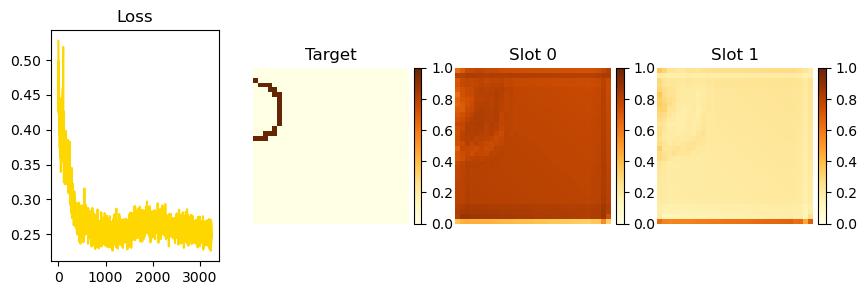

iter 3500 , loss 0.2256396 , lr 8.919053362520407e-05


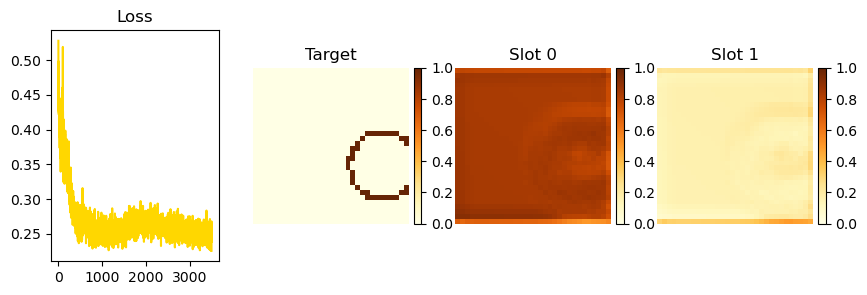

iter 3750 , loss 0.23288631 , lr 8.178807994989432e-05


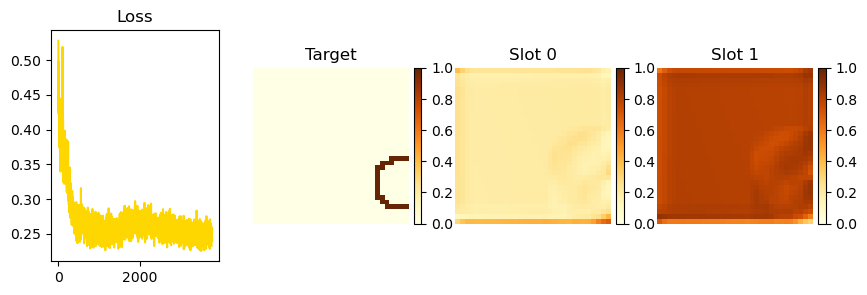

iter 4000 , loss 0.2435504 , lr 7.5e-05


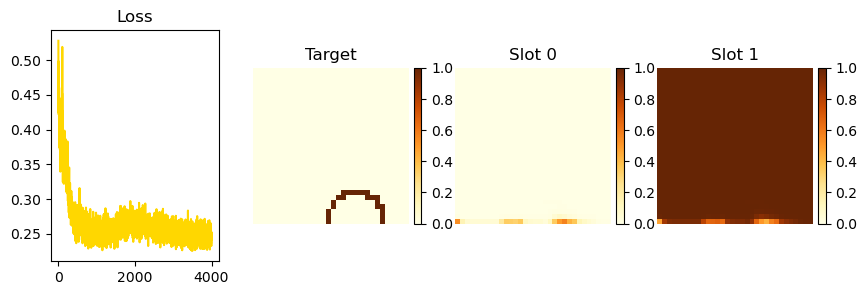

iter 4250 , loss 0.26303905 , lr 6.877530324035033e-05


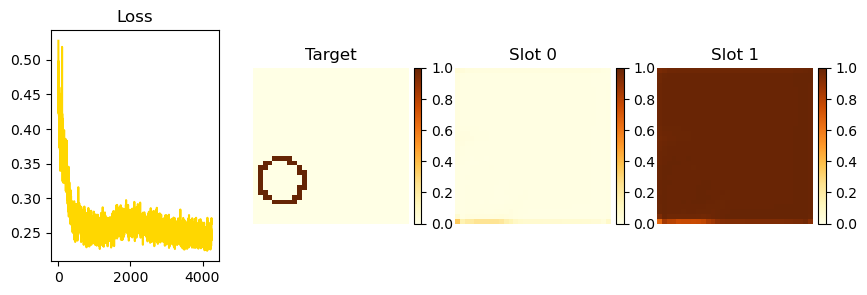

In [ ]:
bs = 256

sa_pe = SlotAttentionPosEmbed(k_slots=2,device=device).to(device)

sa_pe,L_pe = train(sa_pe, 8_000, bs=bs,device=device, color='gold',cmap="YlOrBr")

For completeness, let's _also_ include the version of positional embedding that Lukas had, putting the positional embedding as an extra input.

In [ ]:
class SlotAttentionLHPosEmbed(torch.nn.Module):
    def __init__(self, 
                 resolution=(32,32),
                 k_slots=3, 
                 hidden_dim=32, 
                 query_dim=32, 
                 n_iter=2,
                 device='cpu', 
                 ):
        '''
        Slot attention encoder block -- using the positional embedding
        appended as an additional input feature.

        Inputs:
        - device (cpu, mps, cuda): Which device to put the model on 
                (needed for the random call when initializing the slots)
        - k_slots: number of slots (note, can vary between training and test time)
        - hidden_dim: The hidden dimension for the CNN (currently single layer w/ no non-linearities)
        - query_dim: The latent space dimension that the slots and the queries get computed in
        - n_iter: Number of slot attention steps to apply (defualt 2, and rn hard coded)
        '''
        super().__init__()

        self.k_slots = k_slots
        self.hidden_dim = hidden_dim
        self.query_dim = query_dim
        self.n_iter = n_iter

        self.device=device
        
        self.dataN = torch.nn.LayerNorm(self.hidden_dim)
        self.queryN = torch.nn.LayerNorm(self.query_dim)
        
        self.toK = torch.nn.Linear(self.hidden_dim, self.query_dim)
        self.toV = torch.nn.Linear(self.hidden_dim, self.query_dim)
        self.gru = torch.nn.GRUCell(self.query_dim, self.query_dim)

        grid = torch.FloatTensor(build_grid(resolution)).to(device)
        self.grid = grid.permute(0,3,1,2) # put the channel dim at dim=1
        
        filter_size=5
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(5,self.hidden_dim,filter_size, padding = 2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(self.hidden_dim,self.hidden_dim,filter_size, padding = 2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(self.hidden_dim,self.hidden_dim,filter_size, padding = 2),
        )
                
    def init_slots(self, Nbatch):
        noise = torch.randn(Nbatch, self.k_slots, self.query_dim).to(self.device)
        
        mu = torch.zeros(1,1,self.query_dim).to(self.device)
        logsigma = torch.zeros(1,1,self.query_dim).to(self.device)
        
        return mu + noise*logsigma.exp()
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
            
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    def attention_and_weights(self,queries,encoded_data):
        keys = self.toK(encoded_data)
        logits = torch.einsum('bse,bde->bsd',queries,keys) * (self.query_dim ** (-0.5)) * 10
        
        if logits.requires_grad:
            h = logits.register_hook(self.activations_hook)
        
        att = torch.nn.functional.softmax(logits, dim = 1)

        div = torch.sum(att, dim = -1, keepdims = True)
        wts = att/div + 1e-8
        return att,wts

    def iterate(self, queries, encoded_data):
        
        # queries: (bs, n_slots, query_dim)
        
        att,wts = self.attention_and_weights(self.queryN(queries),encoded_data)   
        
        # att: (bs, n_slots, img_dim)
        # wts: (bs, n_slots, img_dim)
        
        vals = self.toV(encoded_data) # bs, img_dim, query_dim
        updates = torch.einsum('bsd,bde->bse',wts,vals) # bs, n_slots, query_dim
        
        updates = self.gru(
            updates.reshape(-1,self.query_dim),
            queries.reshape(-1,self.query_dim),
        )

        return updates.reshape(queries.shape)
        
    def forward(self, data):

        Nbatch = data.shape[0]
        
        x = torch.cat([data,x],dim=1)
        
        # Apply the CNN encoder
        encoded_data = self.encoder(data)
        
        # Put the channel dim at the end
        encoded_data = torch.permute(encoded_data,(0,2,3,1)) 
                 
        # Add the positional embeddings
        encoded_data = self.posEnc(encoded_data)
       
        # Flatten the pixel dims and apply the data normalization
        encoded_data = torch.flatten(encoded_data,1,2)
        encoded_data = self.dataN(encoded_data)
    
        for i in range(self.n_iter):
            queries = self.iterate(queries, encoded_data)    
            
        # Then with the _final_ query vector, calc what the attn + weights would be
        att, wts = self.attention_and_weights(self.queryN(queries),encoded_data)   
            
        return queries, att #.reshape(-1,self.k_slots,nPixels,nPixels)
        

In [ ]:
sa_lh = SlotAttentionLHPosEmbed(k_slots=2,device=device).to(device)

sa_lh,L_lh = train(sa_lh, 8_000, bs=bs,device=device, color='C2',cmap="Greens")

In [ ]:
plt.plot(L_de,label='no pos embed')
plt.plot(L_ps,label='Pos embed after CNN enc',color='gold')